# **In this notebook, we analyze, visualize, and prepare the cleaned 'Early Onset Sepsis Prediction' dataset. The goal is to conduct a thorough exploratory analysis and finalize the data for its use in advanced deep learning applications.**

## 1. This first cell handles all the preliminary setup for our project. We're importing all the necessary libraries for data manipulation, machine learning, and plotting. We also define key constants that will be used throughout the notebook, such as file paths and the random seed to ensure our results are reproducible. Finally, we'll define a few helper functions to keep our main code clean and readable.

In [ ]:
from pathlib import Path
import os, sys, json, math, random, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.experimental import enable_iterative_imputer  # noqa: F401
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import ttest_ind, mannwhitneyu, kruskal
from sklearn.linear_model import BayesianRidge
import joblib

# Style for plotting in seaborn and matplotlib
warnings.filterwarnings("ignore")
sns.set_theme(context="notebook", style="whitegrid")
plt.rcParams["figure.dpi"] = 150
plt.rcParams["savefig.dpi"] = 512

# --- Reproducibility ---
seed = 42
np.random.seed(seed)
random.seed(seed)

# --- Paths (Colab defaults) ---
Main_dataset    = Path("/content/drive/MyDrive/Sepsis Prediction/all_patients_data_preprocessed.csv")
Main_dataset_cleaned = Path("/content/outputs/cleaning_pipeline/all_patients_cleaned.csv")
Source         = Main_dataset_cleaned if Main_dataset_cleaned.exists() else Main_dataset

Output_dir         = Path("/content/drive/MyDrive/Sepsis Prediction/content/outputs")


# Helper functions

def ensure_dir(path: Path) -> Path:
    path.mkdir(parents=True, exist_ok=True)
    return path

def load_any(path: Path) -> pd.DataFrame:
    suf = path.suffix.lower()
    if suf in {".parquet", ".pq"}:
        return pd.read_parquet(path)
    elif suf == ".csv":
        return pd.read_csv(path, low_memory=False)
    else:
        raise ValueError(f"Unsupported source extension: {suf}")

Show_inline = True  # flip to False to save plots only (faster)
def save_and_show(fig, path: Path):
    fig.tight_layout()
    fig.savefig(path, dpi=512)
    if Show_inline :
        from IPython.display import display
        display(fig)
    plt.close(fig)

def get_time_col(df: pd.DataFrame) -> str:
    if "Hour" in df.columns:   return "Hour"
    raise KeyError("No time column found: 'Hour'.")


## 2. Data Cleaning and Preparation

### 2.1. **Configuration: Defining Parameters and Feature Sets**
**What:** We are defining all the crucial variables and parameters that will control our data cleaning and feature engineering pipeline.

**Why:** Centralizing these parameters in one place makes the code cleaner, easier to read, and simpler to modify. If we want to test a different outlier threshold or imputation strategy, we only need to change it here instead of searching through the entire script.

**How:** We assign simple string names to key columns (id, time, Sepsis). We set numerical parameters for imputation (Hrs_max, fill_limit, K) and outlier handling (z_thrsh, winsor_qs). We also create lists of strings (Vitals, Labs) to easily manage and select these groups of features later on.

In [ ]:
id = "PatientID"
time  = "Hour"
Sepsis = "SepsisLabel"

# LOCF/interp + imputation + outliers
Hrs_max = 6          # carry forward AT MOST this many hours (can be changed)
fill_limit  = 6          # linear interpolation (vitals), max consecutive NaNs to fill
itr_im = True       # True: IterativeImputer(RandomForest), False: KNNImputer
K = 5          # neighbors for KNNImputer
z_thrsh  = 3.5        # robust z-threshold for outlier flagging
winsor_qs     = (0.01, 0.99)

# Feature sets
Vitals = ["Temp","HR","O2Sat","SBP","MAP","DBP","Resp"]
Labs   = ["Lactate","Creatinine","WBC","Platelets","Bilirubin_total","BUN","Glucose",
          "Calcium","Chloride","Magnesium","Phosphate","Potassium","Hct","Hgb","AST","Alkalinephos"]

# -------- Paths --------
out_dir_cl = ensure_dir(Output_dir  / "cleaning_pipeline")

### **2.2 Data Loading and Initial Preparation**
**What:** We are loading the dataset from the specified source file, ensuring the required ID and time columns are present, and casting all feature columns to the correct numeric data type.

**Why:** This step ensures our data is in a consistent and predictable format before we begin any complex manipulations. By converting columns to numeric types, we can perform mathematical operations on them. Sorting by patient and time is critical for time-series operations like forward-filling.

**How:** We use our custom load_any function to read the data. An assert statement confirms that the PatientID and Hour columns exist. We then loop through our predefined Vitals and Labs lists to apply pd.to_numeric, which converts values to numbers and gracefully handles any errors by turning non-numeric entries into NaN. Finally, we sort the DataFrame and print its shape.

In [ ]:
df = load_any(Source)
assert {id, time}.issubset(df.columns), f"Missing {id}/{time}."

# Cast numerics
df[time] = pd.to_numeric(df[time], errors="coerce")
if Sepsis in df.columns:
    df[Sepsis] = pd.to_numeric(df[Sepsis], errors="coerce").fillna(0).astype(int)
for c in (Vitals + Labs):
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Keep only columns present
Vitals   = [c for c in Vitals if c in df.columns]
Labs     = [c for c in Labs   if c in df.columns]
num_cols = Vitals + Labs

# Sort for time-aware ops
df = df.sort_values([id, time]).reset_index(drop=True)
print(f"Loaded: {df.shape} | VITALS={len(Vitals)} | LABS={len(Labs)}")


Loaded: (1552210, 63) | VITALS=7 | LABS=16


### **2.3. Sanity Check: Removing Physiologically Implausible Values**
**What:** We are identifying and removing data points that are physiologically impossible or nonsensical (e.g., a heart rate of 500 bpm, a temperature of 0°C).

**Why:** These extreme values are almost certainly data entry errors or measurement malfunctions. Keeping them would skew our analysis, imputation, and outlier detection. By converting them to NaN (Not a Number), we mark them as missing so they can be handled properly in the next steps.

**How:** We define a dictionary called bounds that stores the plausible minimum and maximum values for each vital sign and lab test. We then iterate through each feature column, check if a value falls outside its predefined range, and replace it with np.nan if it does.

In [ ]:
bounds = {"HR": (20, 250), "Temp": (25, 45), "O2Sat": (0, 100), "SBP": (30, 300), "MAP": (20, 200), "DBP": (10, 200), "Resp": (0, 80),"Lactate": (0, 20), "Creatinine": (0, 15), "WBC": (0, 200), "Platelets": (0, 2000),
    "Bilirubin_total": (0, 40), "BUN": (0, 200), "Glucose": (0, 1000), "Calcium": (0, 20), "Chloride": (50, 150), "Magnesium": (0, 10), "Phosphate": (0, 20), "Potassium": (1, 9), "Hct": (5, 80), "Hgb": (2, 25),
    "AST": (0, 5000), "Alkalinephos": (0, 3000),}
stage0_set_nan = {}
for c in num_cols:
    if c in bounds:
        lo, hi = bounds[c]
        bad = df[c].notna() & ((df[c] < lo) | (df[c] > hi))
        stage0_set_nan[c] = int(bad.sum())
        df.loc[bad, c] = np.nan
    else:
        stage0_set_nan[c] = 0
print("Stage 2.3 (Sanity Check) complete. Implausible values have been set to NaN.")

Stage 2.3 (Sanity Check) complete. Implausible values have been set to NaN.


### 2.4. Time-Aware Imputation (Part 1): Forward Fill and Interpolation
**What:** We are performing the first layer of missing value imputation using time-aware methods. This involves a capped "Last Observation Carried Forward" (LOCF) and a limited linear interpolation.

**Why:** In clinical data, a recent measurement is often a good estimate for a current missing one. LOCF carries the last known value forward, but we cap it (Hrs_max) to prevent using "stale" data from too long ago. Linear interpolation is used for vital signs, as they tend to change smoothly and predictably over short periods. This is a more intelligent approach than simple mean or median imputation.

**How:** We define a highly optimized function time_aware_baselines_fast that groups the data by patient. For each patient, it vectorizes the LOCF operation and calculates the time gap since the last valid measurement. If a gap exceeds Hrs_max, the forwarded value is nullified. It then applies linear interpolation with a limit to fill small, consecutive gaps in vital signs.

In [ ]:
def time_aware_baselines_fast(df_in: pd.DataFrame,cols_all, cols_interp, id_col=id, tcol=time, max_gap_hours=Hrs_max, interp_limit=fill_limit, show_pbar=True):
    out_parts = []
    gb = df_in.groupby(id_col, sort=False)
    iterator = gb
    total = gb.ngroups

    if show_pbar:
        iterator = tqdm(gb, total=total, unit="patient",
                        desc="Stage 1: capped LOCF + limited interp", leave=False)

    for pid, g in iterator:
        # --- numpy views ---
        t = g[tcol].to_numpy(dtype=float)                 # (n,)
        A = g[cols_all].to_numpy(dtype=float)             # (n, p)

        # --- LOCF with time-aware staleness (vectorized across columns) ---
        # forward-fill values
        A_ff = pd.DataFrame(A).ffill().to_numpy()         # (n, p)

        # last valid time for each column at each row
        T = np.broadcast_to(t[:, None], A.shape)          # (n, p)
        last_t = pd.DataFrame(np.where(~np.isnan(A), T, np.nan)).ffill().to_numpy()

        # stale mask: time since last valid > max_gap_hours
        stale = (T - last_t) > float(max_gap_hours)
        A_ff[stale] = np.nan

        g2 = g.copy()
        g2[cols_all] = A_ff

        # --- limited linear interpolation for vitals (single pass) ---
        if cols_interp:
            g2[cols_interp] = g2[cols_interp].interpolate(
                method="linear", limit=int(interp_limit), limit_direction="both"
            )

        out_parts.append(g2)

    return pd.concat(out_parts, axis=0)


df = time_aware_baselines_fast(df, cols_all=num_cols, cols_interp=Vitals,
                               id_col=id, tcol=time,
                               max_gap_hours=Hrs_max, interp_limit=fill_limit,
                               show_pbar=True)
print("Stage 2.4 completed.")

Stage 2.4 completed.


### **2.5. Advanced Imputation (Part 2): Per-Patient Modeling**
**What:** We are filling the remaining missing values. We use a sophisticated K-Nearest Neighbors (KNN) imputer for vital signs and a simple per-patient median for lab values.

**Why:** Vitals are frequently measured and correlated within a single patient's timeline. KNN is a powerful choice because, for each patient, it finds other time points (neighbors) where the recorded vital signs were most similar to the time point with the missing value. It then uses the data from these 'neighboring' hours to intelligently fill the gap. This captures the internal correlations within a single patient's unique physiology over time. Labs, being sparser, are filled with a simple per-patient median, which is a robust and safer choice.

**How:** We define a function knn_per_patient_inplace that groups by patient and applies KNNImputer to the vital signs of each patient individually. For labs, we use a single, highly efficient line of code with .groupby(id).transform() to calculate and fill with the median for each patient's entire record.

In [ ]:
K = 3
KNN_WEIGHTS = "uniform"

# Build lists based on your naming and what's present
exclude = {id, time, Sepsis}
num_matrix_cols = [c for c in df.columns if c not in exclude and pd.api.types.is_numeric_dtype(df[c])]

vitals_cols = [c for c in Vitals if c in df.columns]
labs_cols   = [c for c in Labs   if c in df.columns]

vital_miss = int(df[vitals_cols].isna().sum().sum()) if vitals_cols else 0
lab_miss   = int(df[labs_cols].isna().sum().sum()) if labs_cols else 0
print(f"Stage 2/3 (recommended): vitals missing = {vital_miss:,} | labs missing = {lab_miss:,}")

def knn_per_patient_inplace(df_in: pd.DataFrame, cols, k=3, weights="uniform"):
    """Per-patient KNN on selected columns; assigns in place with a progress bar."""
    if not cols:
        return
    gb = df_in.groupby(id, sort=False)
    for pid, g in tqdm(gb, total=gb.ngroups, unit="patient",
                       desc=f"Per-patient KNN (k={k}, {len(cols)} cols)", leave=False):
        # Use only columns that have at least one non-NaN for THIS patient
        cols_g = [c for c in cols if g[c].notna().any()]
        if not cols_g:
            continue
        # Skip if there are no NaNs to fill for this patient in these cols
        if not g[cols_g].isna().values.any():
            continue
        imp = KNNImputer(n_neighbors=k, weights=weights)
        X_imp = imp.fit_transform(g[cols_g].to_numpy(dtype="float32", copy=False))
        df_in.loc[g.index, cols_g] = X_imp

# 1) Vitals: per-patient KNN
if vital_miss > 0 and vitals_cols:
    knn_per_patient_inplace(df, vitals_cols, k=K, weights=KNN_WEIGHTS)
    print("Impute: per-patient KNN on vitals complete.")
else:
    print("Impute: no missing in vitals or no vitals present — skipping KNN.")

# 2) Labs: per-patient median (vectorized, fast)
if lab_miss > 0 and labs_cols:
    df[labs_cols] = df.groupby(id, sort=False)[labs_cols].transform(lambda g: g.fillna(g.median()))
    print("Impute: per-patient median on labs complete.")
else:
    print("Impute: no missing in labs or no labs present — skipping median.")

# Summary
total_after = int(df[[c for c in num_matrix_cols if c in df.columns]].isna().sum().sum())
print(f"Stage 2.5. complete. Remaining missing (numeric features): {total_after:,}")

Stage 2/3 (recommended): vitals missing = 358,036 | labs missing = 7,320,962


Impute: per-patient KNN on vitals complete.
Impute: per-patient median on labs complete.
Stage 2.5. complete. Remaining missing (numeric features): 45,642,642


### **2.6. Outlier Handling: Robust Z-Score and Winsorization**
**What:** We are identifying and capping extreme values (outliers) that might still exist after our initial sanity checks. This process is often called "Winsorization."

**Why:** Even after imputation, some values might be physiologically possible but statistically extreme for our dataset, potentially harming the performance of machine learning models. Instead of removing them, we cap them at a reasonable percentile (e.g., the 99th percentile). This retains the information that the value was high or low without letting its extreme magnitude distort the model.

**How:** We use a "robust" Z-score, which is based on the median and Median Absolute Deviation (MAD) instead of the mean and standard deviation, making it less sensitive to outliers themselves. We define a function robust_z_vec to calculate this score. For each feature, we identify values with a robust Z-score above our threshold (z_thrsh) and clip them to the 1st and 99th percentiles (winsor_qs) of that feature's distribution.

In [ ]:
def robust_z_vec(x: pd.Series) -> np.ndarray:
    xv = x.to_numpy(dtype=float)
    med = np.nanmedian(xv)
    mad = np.nanmedian(np.abs(xv - med))
    if not np.isfinite(mad) or mad == 0:
        return np.zeros_like(xv, dtype=float)
    return 0.6745 * (xv - med) / mad

winsor_counts = {}
q_low, q_high = winsor_qs

iter_cols = [c for c in num_cols if c in df.columns]
for c in tqdm(iter_cols, desc="Stage 4: winsorizing", unit="feat", leave=False):
    x = df[c]
    if x.isna().all():
        winsor_counts[c] = 0
        continue

    rz = robust_z_vec(x)
    mask = np.abs(rz) > float(z_thrsh)

    lo_cap = np.nanpercentile(x.to_numpy(dtype=float), q_low * 100.0)
    hi_cap = np.nanpercentile(x.to_numpy(dtype=float), q_high * 100.0)

    before = int(np.nansum(mask))
    if before > 0:
        xc = x.to_numpy(dtype=float)
        idx = np.where(mask & ~np.isnan(xc))
        xc[idx] = np.clip(xc[idx], lo_cap, hi_cap)
        df[c] = xc

    winsor_counts[c] = before

print("Stage 2.6: winsorization complete.")

Stage 2.6: winsorization complete.


## **3. Patient-Level Exploratory Data Analysis (EDA)**
This section transitions from time-series data to a patient-level summary. The goal is to create a single row for each patient that captures their overall clinical picture. We will use this summary to compare septic and non-septic patient populations, identify the most discriminative features, and visualize the differences between the two groups.

### **3.1. Loading and Setup**
**What:** We are loading the cleaned dataset and ensuring it has the required columns (PatientID, Hour, SepsisLabel). We then verify that all our feature columns (Vitals and Labs) are in the correct numeric format for calculations.

**Why:** This is a crucial first step to set the stage for analysis. By confirming the data's integrity and format, we prevent errors in the more complex aggregation and plotting steps that follow.

**How:** We define the path to the cleaned data and load it using our load_any helper function. We perform a sanity check to ensure essential columns exist. Finally, we loop through our feature lists, applying pd.to_numeric to each column.

In [ ]:
# -------- Resolve paths (use cleaned if present) --------
EDA_OUT = ensure_dir(Output_dir / "eda_patient_level")
CLEANED = Output_dir / "cleaning_pipeline" / "all_patients_cleaned.csv"
SRC_EDA = CLEANED if CLEANED.exists() else Source

print(f"Using dataset: {SRC_EDA}")

# -------- Load --------
df = load_any(SRC_EDA)

# -------- Sanity --------
required = {id, time, Sepsis}
missing = required - set(df.columns)
if missing:
    raise ValueError(f"Missing required columns: {missing}")

# Ensure numeric
df[time] = pd.to_numeric(df[time], errors="coerce")
df[Sepsis] = pd.to_numeric(df[Sepsis], errors="coerce").fillna(0).astype(int)

# Keep only existing vitals/labs
Vitals = [c for c in Vitals if c in df.columns]
Labs   = [c for c in Labs   if c in df.columns]
num_cols = Vitals + Labs
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Sort for safety
df = df.sort_values([id, time]).reset_index(drop=True)

print(f"Rows: {len(df):,} | Vitals: {len(Vitals)} | Labs: {len(Labs)} | Numeric cols used: {len(num_cols)}")


Using dataset: /content/drive/MyDrive/Sepsis Prediction/all_patients_data_preprocessed.csv
Rows: 1,552,210 | Vitals: 7 | Labs: 16 | Numeric cols used: 23


### **3.2. Creating the Patient-Level Summary Table**
**What:** We are aggregating the time-series data to create a single summary row for each unique patient. This summary includes demographic data, the total observation time, and the average (mean) value for each vital and lab measurement.

**Why:** A patient-level view is essential for comparing populations. It allows us to directly compare the "typical" septic patient to the "typical" non-septic patient, which is impossible when looking at hour-by-hour data.

**How:** We use df.groupby(id) to group all rows by patient. We then perform a series of aggregations: .max() to determine if a patient ever developed sepsis, .min() and .max() on the Hour column to find the time span, and .mean() on all numeric features to get the patient's average values.

In [ ]:
# -------- Helper Function Definitions --------
def first_non_null(s: pd.Series):
    """Gets the first valid value in a series, useful for static patient data like Age."""
    idx = s.first_valid_index()
    return s.loc[idx] if idx is not None else np.nan

def cohens_d(a: pd.Series, b: pd.Series) -> float:
    """Calculates Cohen's d to measure the effect size between two groups."""
    a = a.dropna(); b = b.dropna()
    if len(a) < 2 or len(b) < 2:
        return np.nan
    m1, m2 = a.mean(), b.mean()
    s1, s2 = a.std(ddof=1), b.std(ddof=1)
    n1, n2 = len(a), len(b)
    denom = (n1 + n2 - 2)
    sp = np.sqrt(((n1-1)*s1*s1 + (n2-1)*s2*s2) / denom) if denom > 0 else np.nan
    return (m1 - m2) / sp if (sp and sp > 0) else np.nan


# -------- Patient-level Aggregation --------
grp = df.groupby(id, sort=False)

# Determine if a patient ever had sepsis
patient_summary = grp[[Sepsis]].max().rename(columns={Sepsis: "HasSepsis"}).astype(int)

# Aggregate demographic and metadata
meta_cols = [c for c in ["Hospital", "Age", "Gender", "Unit1", "Unit2"] if c in df.columns]
for mc in meta_cols:
    patient_summary[mc] = grp[mc].apply(first_non_null)

# Aggregate time-based features
patient_summary["FirstHour"] = grp[time].min()
patient_summary["LastHour"]  = grp[time].max()
patient_summary["NumRows"]   = grp.size()

# Calculate per-patient means for all vitals and labs
if num_cols:
    means_df = grp[num_cols].mean()
    means_df.columns = [f"{c}_mean" for c in means_df.columns]
    patient_summary = patient_summary.join(means_df)

# Final cleanup and cohort separation
patient_summary = patient_summary.reset_index().rename(columns={id: "PatientID"})
septic = patient_summary[patient_summary["HasSepsis"] == 1].reset_index(drop=True)
nonseptic = patient_summary[patient_summary["HasSepsis"] == 0].reset_index(drop=True)

# -------- Save patient tables --------
patient_summary.to_csv(EDA_OUT / "patient_summary_all.csv", index=False)
septic.to_csv(EDA_OUT / "patient_summary_septic.csv", index=False)
nonseptic.to_csv(EDA_OUT / "patient_summary_nonseptic.csv", index=False)

print("Saved patient summaries to:", EDA_OUT)

Saved patient summaries to: /content/drive/MyDrive/Sepsis Prediction/content/outputs/eda_patient_level


### **3.3. Calculating Feature Importance (Effect Size)**
**What:** We are calculating the effect size (specifically Cohen's d) for each feature. This tells us the magnitude of the difference between the septic and non-septic groups for that feature.

**Why:** A simple difference in means can be misleading. Cohen's d standardizes this difference, giving us a clear, comparable metric of how "important" or "discriminative" each feature is in distinguishing between the two populations. This helps us focus on the most clinically relevant signals.

**How:** We loop through each feature's mean value (_mean columns). In each loop, we pass the series of septic patient values and non-septic patient values to our cohens_d helper function. The results are stored in a new DataFrame and sorted to show the most impactful features at the top.



In [ ]:
# -------- Compute Cohen's d for per-patient means --------
effect_rows = []
mean_cols = [f"{c}_mean" for c in num_cols if f"{c}_mean" in patient_summary.columns]

for col in tqdm(mean_cols, desc="Computing Cohen's d", unit="feat", leave=False):
    base_name = col[:-5]  # strip "_mean"
    septic_vals = septic[col]
    nonseptic_vals = nonseptic[col]

    d_val = cohens_d(septic_vals, nonseptic_vals)

    effect_rows.append([base_name,
                        septic_vals.mean(),
                        nonseptic_vals.mean(),
                        d_val])

effects = pd.DataFrame(effect_rows, columns=["feature", "mean_septic", "mean_nonseptic", "cohens_d"])
effects = effects.sort_values(by="cohens_d", key=abs, ascending=False)
effects.to_csv(EDA_OUT / "feature_effect_sizes_cohens_d.csv", index=False)
print("Saved effect sizes to:", EDA_OUT / "feature_effect_sizes_cohens_d.csv")

Saved effect sizes to: /content/drive/MyDrive/Sepsis Prediction/content/outputs/eda_patient_level/feature_effect_sizes_cohens_d.csv


### **3.4. Visualizing Feature Distributions**
**What:** We are creating box-and-strip plots for each feature. This visualization shows the distribution of the per-patient mean values for both the septic and non-septic cohorts.

**Why:** Visualizations make it much easier to understand the differences between the two groups than just looking at numbers. The box plot summarizes the distribution (median, quartiles), while the strip plot shows every individual patient, giving us a complete and intuitive picture of the data.

**How:** We loop through each numeric feature. For each one, we create a figure using matplotlib and then use seaborn's boxplot and stripplot functions to draw the plots, separating the data by the "Cohort" (Septic vs. Non-septic). Each plot is then saved to a file.

Patient-level prevalence → Patients: 40,336 | Septic: 2,932 (7.3%)


Plots: box+strip:   0%|          | 0/23 [00:00<?, ?feat/s]

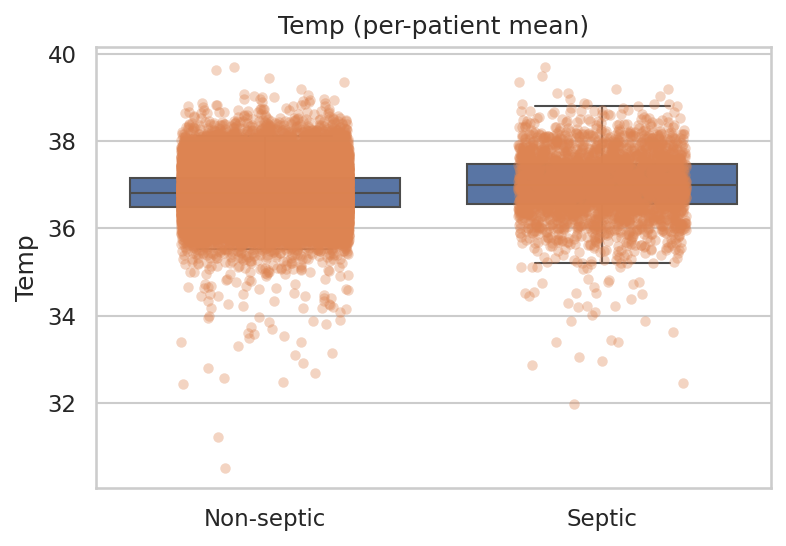

Plots: box+strip:   4%|▍         | 1/23 [00:01<00:43,  1.96s/feat]

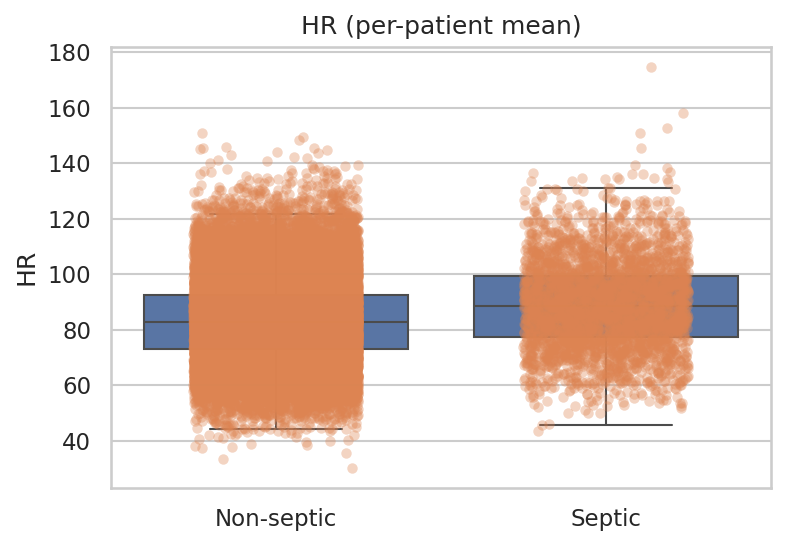

Plots: box+strip:   9%|▊         | 2/23 [00:03<00:39,  1.89s/feat]

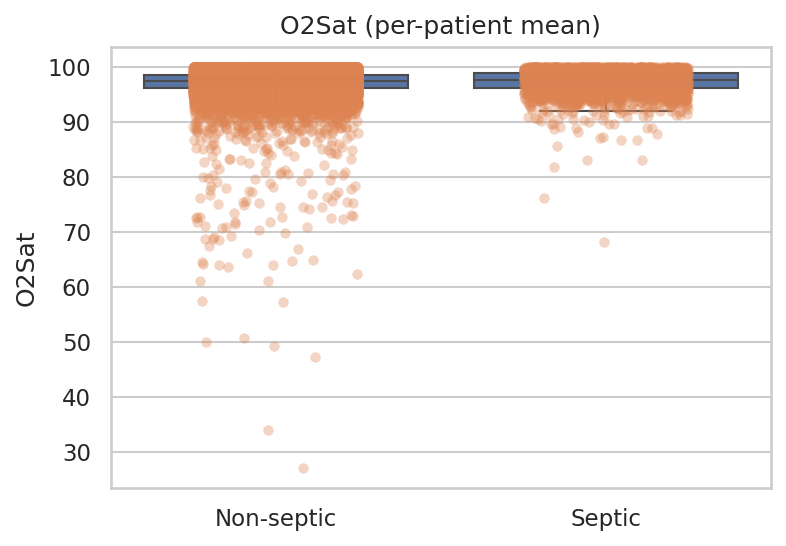

Plots: box+strip:  13%|█▎        | 3/23 [00:05<00:36,  1.83s/feat]

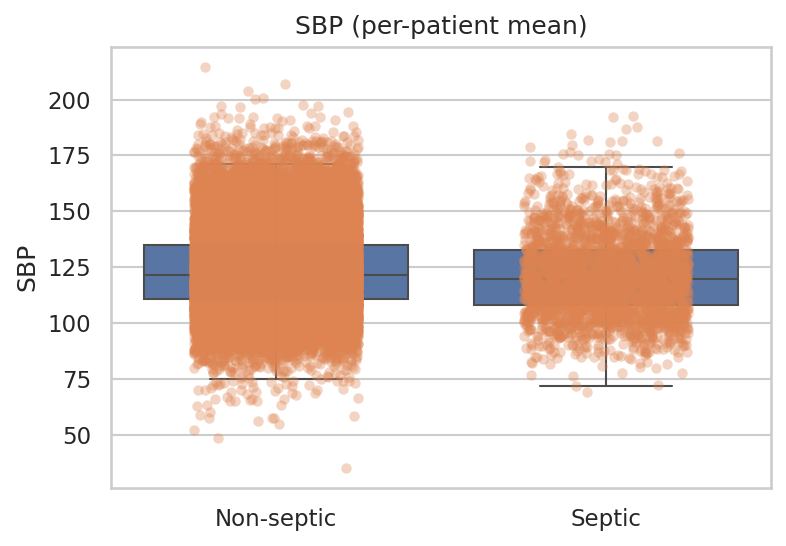

Plots: box+strip:  17%|█▋        | 4/23 [00:07<00:37,  1.97s/feat]

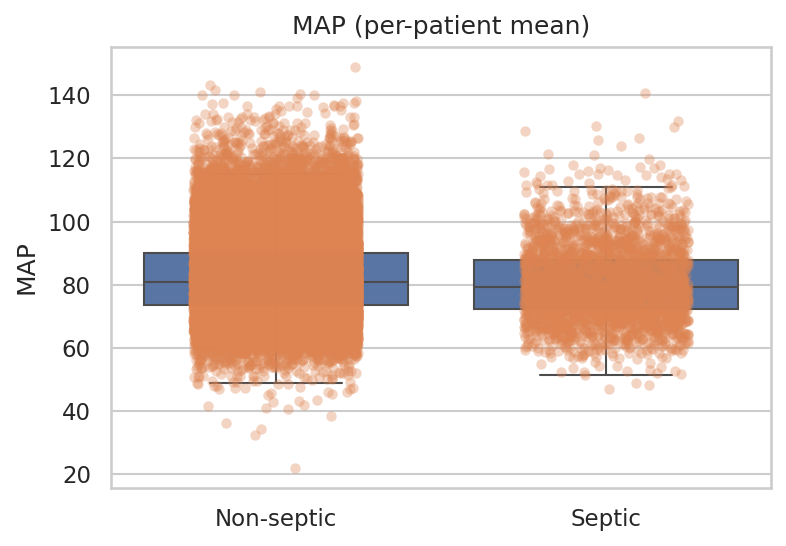

Plots: box+strip:  22%|██▏       | 5/23 [00:09<00:35,  1.95s/feat]

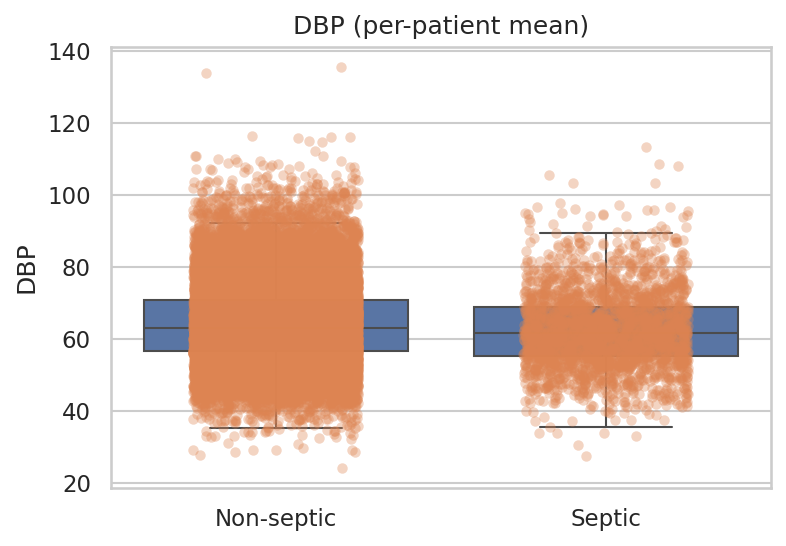

Plots: box+strip:  26%|██▌       | 6/23 [00:11<00:32,  1.92s/feat]

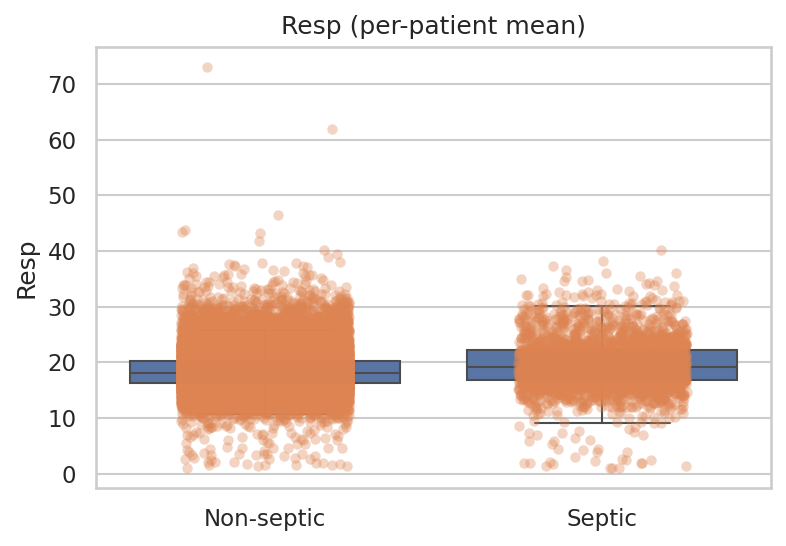

Plots: box+strip:  30%|███       | 7/23 [00:13<00:29,  1.86s/feat]

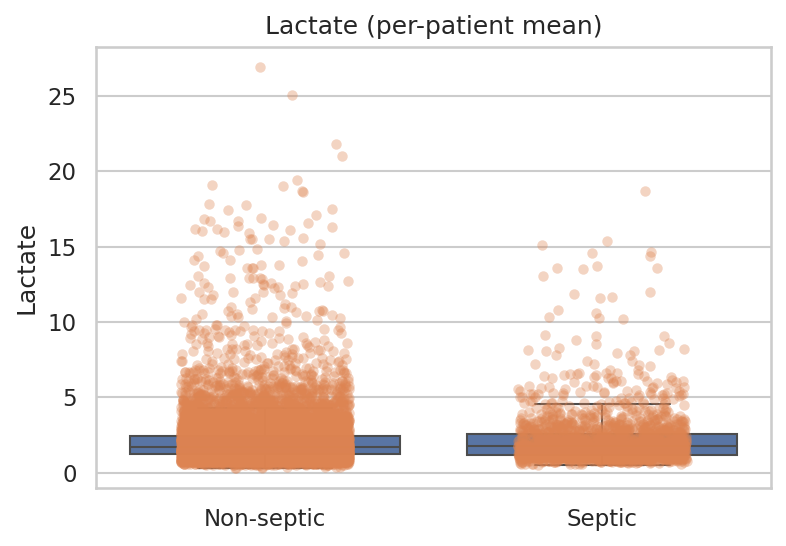

Plots: box+strip:  35%|███▍      | 8/23 [00:14<00:25,  1.72s/feat]

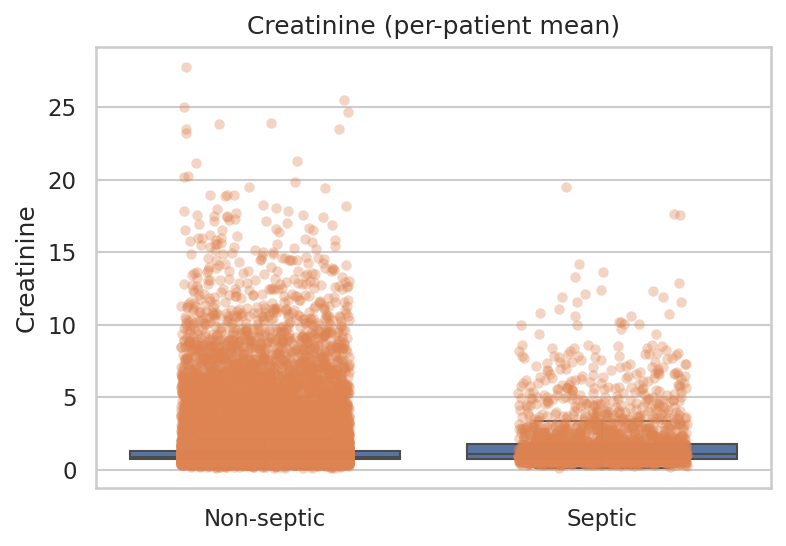

Plots: box+strip:  39%|███▉      | 9/23 [00:16<00:25,  1.81s/feat]

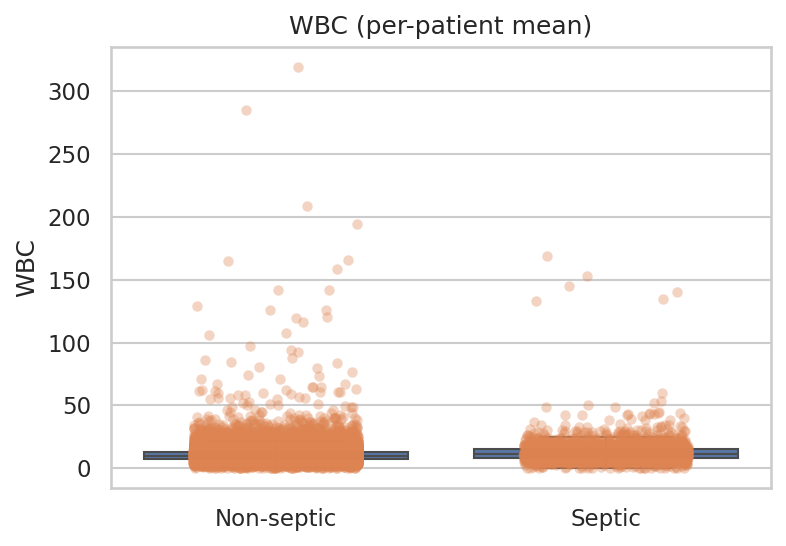

Plots: box+strip:  43%|████▎     | 10/23 [00:18<00:22,  1.74s/feat]

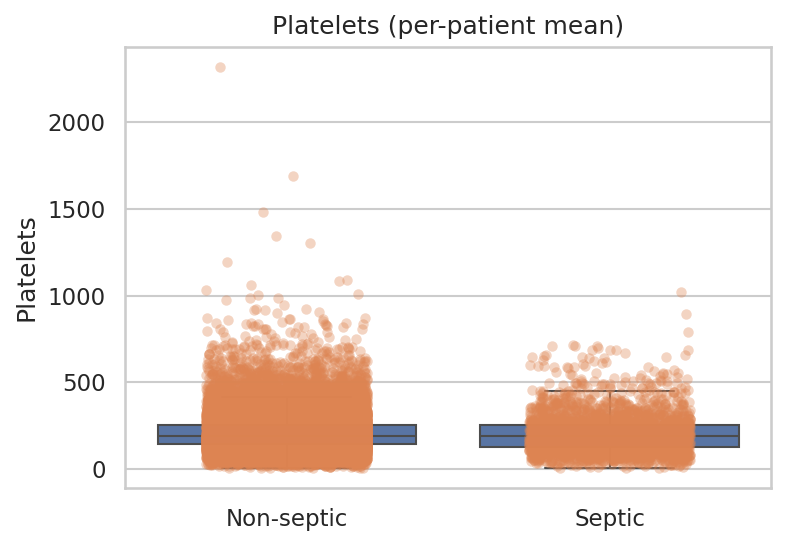

Plots: box+strip:  48%|████▊     | 11/23 [00:19<00:20,  1.73s/feat]

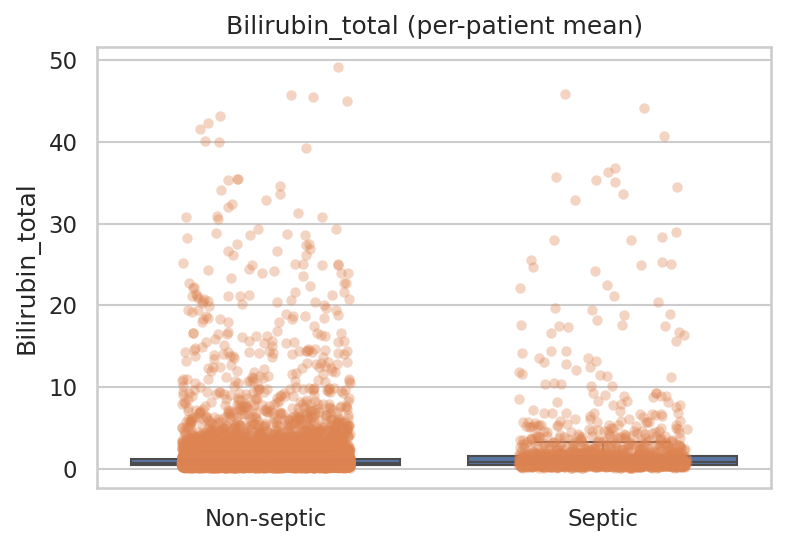

Plots: box+strip:  52%|█████▏    | 12/23 [00:21<00:17,  1.61s/feat]

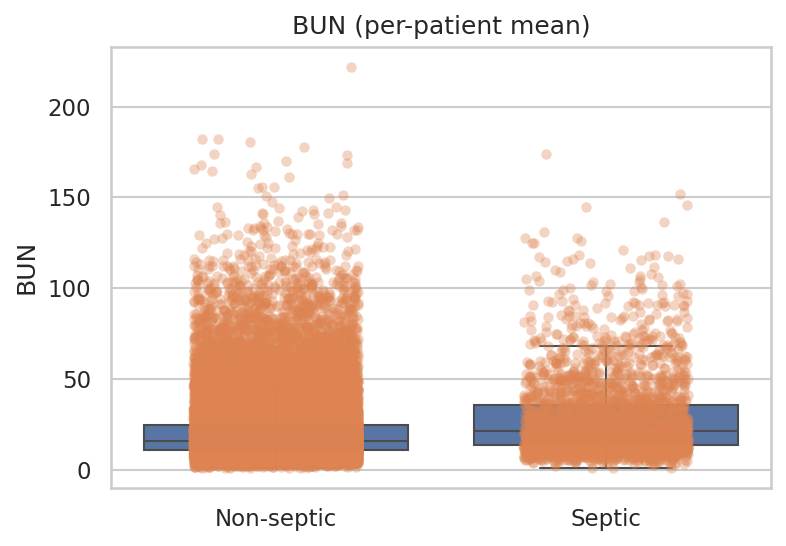

Plots: box+strip:  57%|█████▋    | 13/23 [00:22<00:16,  1.63s/feat]

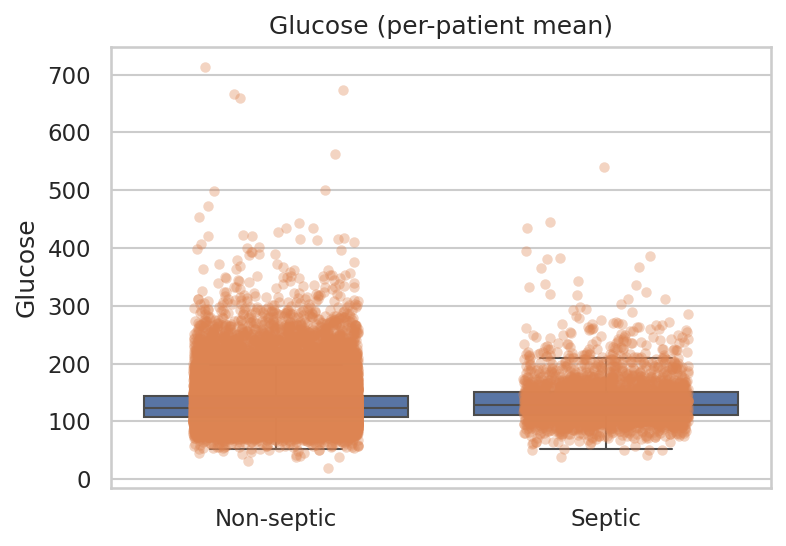

Plots: box+strip:  61%|██████    | 14/23 [00:24<00:15,  1.67s/feat]

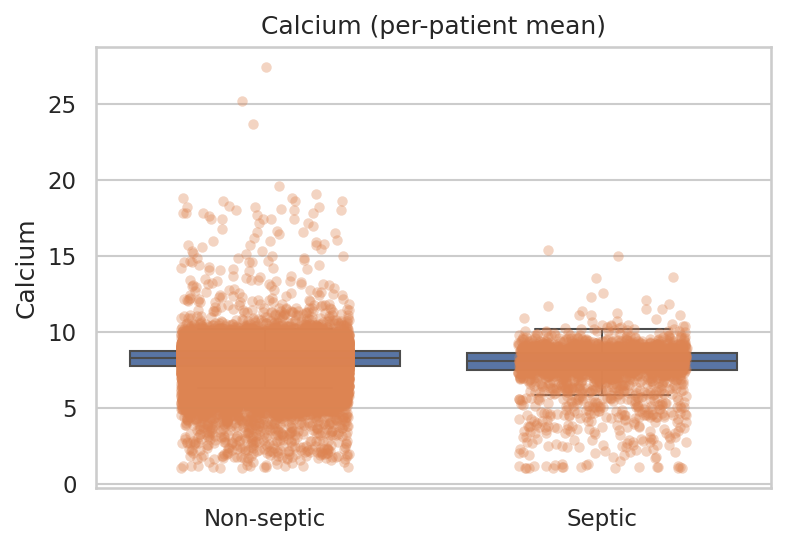

Plots: box+strip:  65%|██████▌   | 15/23 [00:26<00:13,  1.70s/feat]

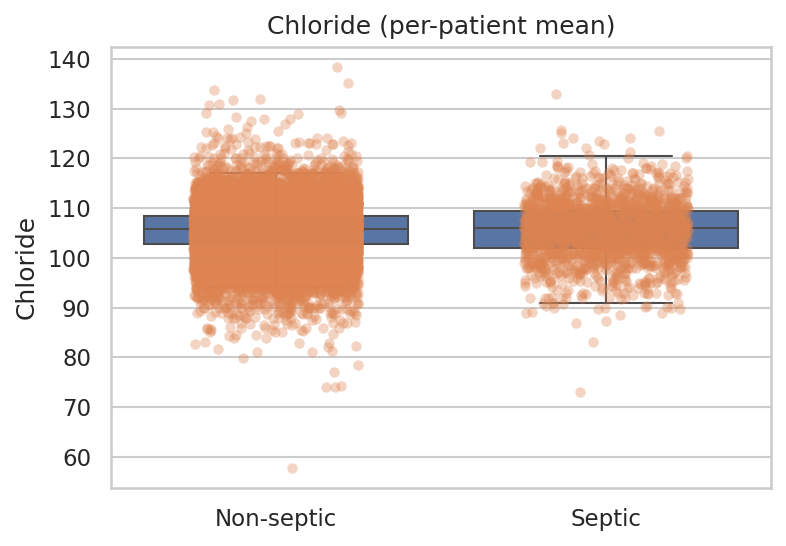

Plots: box+strip:  70%|██████▉   | 16/23 [00:28<00:11,  1.64s/feat]

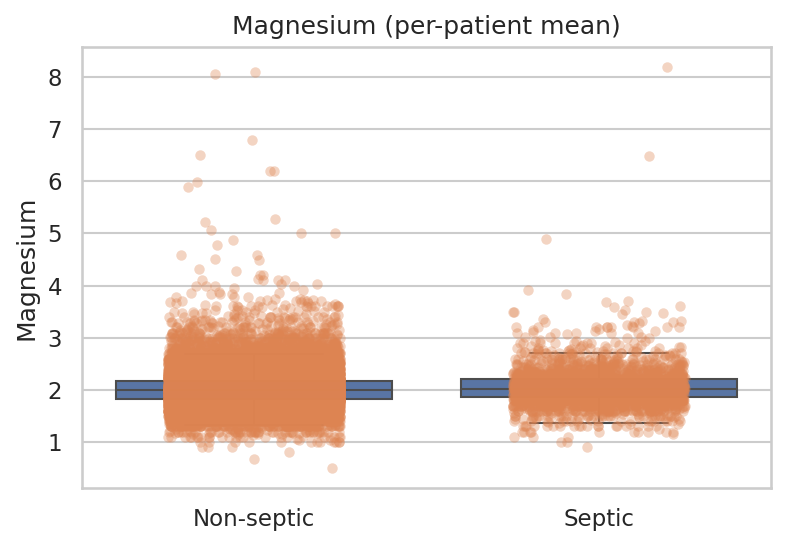

Plots: box+strip:  74%|███████▍  | 17/23 [00:29<00:09,  1.63s/feat]

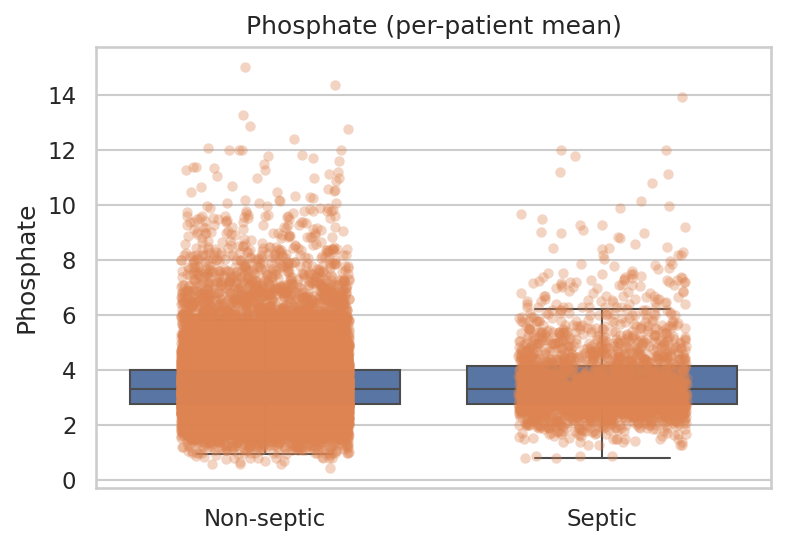

Plots: box+strip:  78%|███████▊  | 18/23 [00:31<00:08,  1.64s/feat]

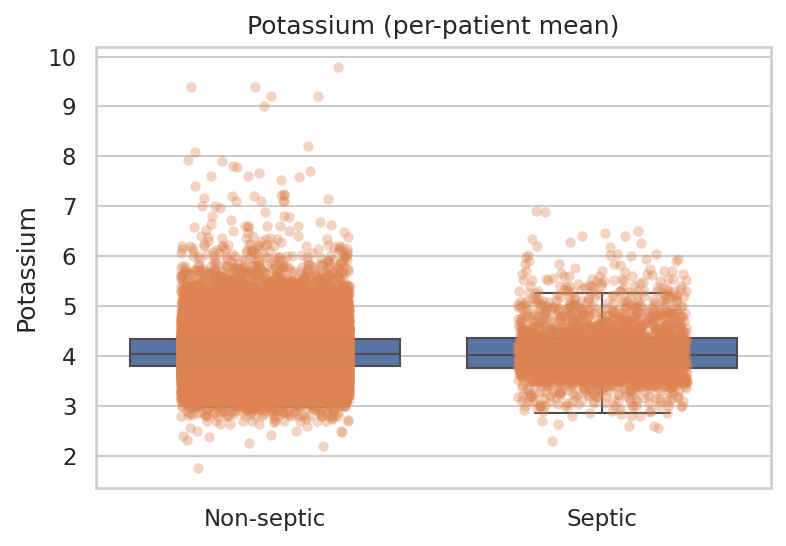

Plots: box+strip:  83%|████████▎ | 19/23 [00:32<00:06,  1.65s/feat]

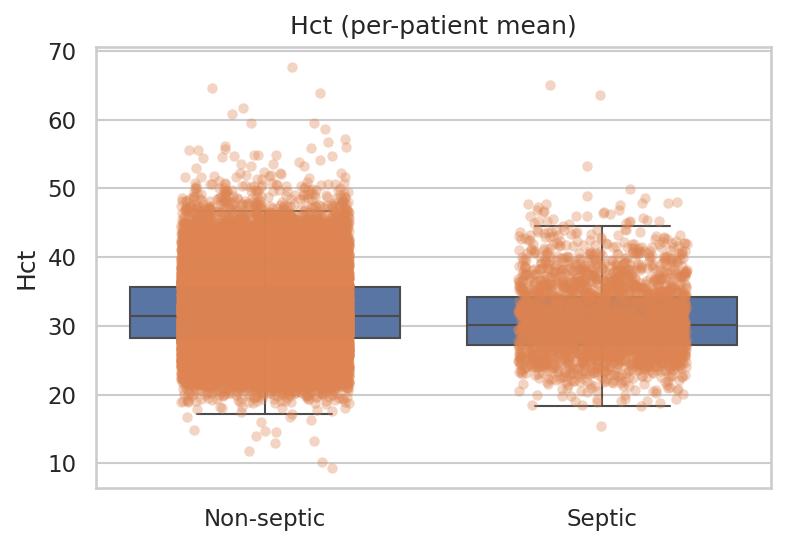

Plots: box+strip:  87%|████████▋ | 20/23 [00:34<00:05,  1.68s/feat]

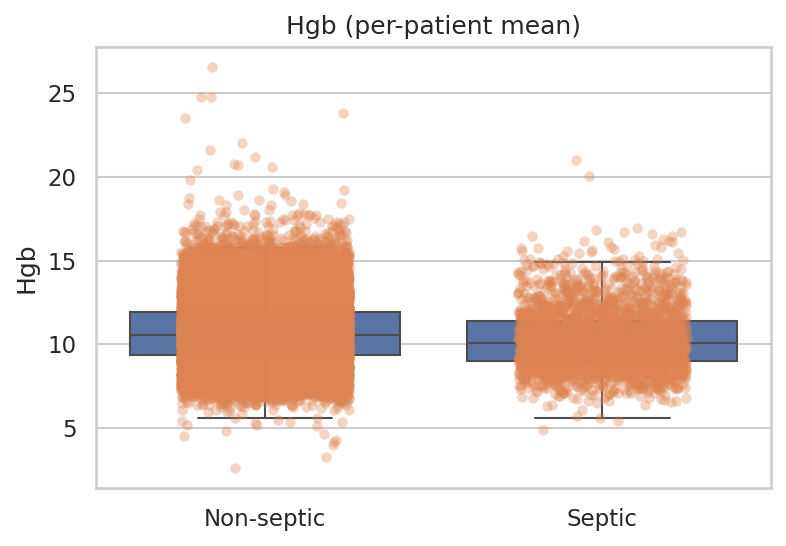

Plots: box+strip:  91%|█████████▏| 21/23 [00:36<00:03,  1.70s/feat]

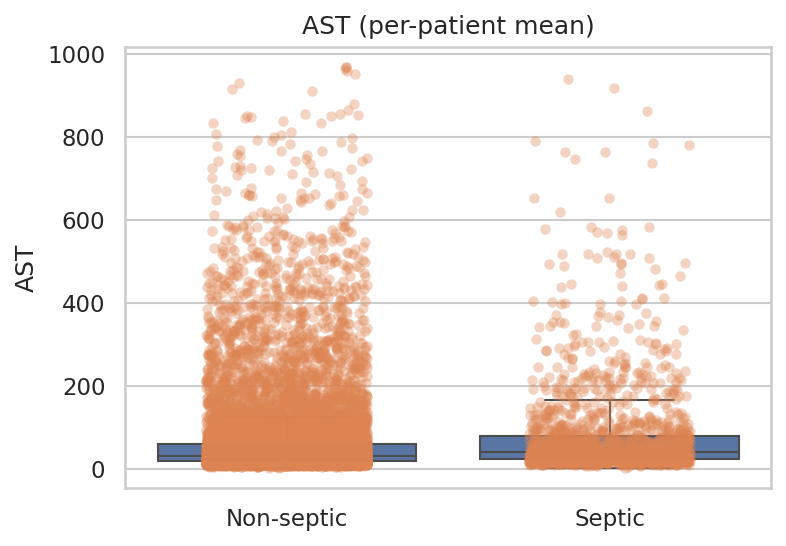

Plots: box+strip:  96%|█████████▌| 22/23 [00:38<00:01,  1.67s/feat]

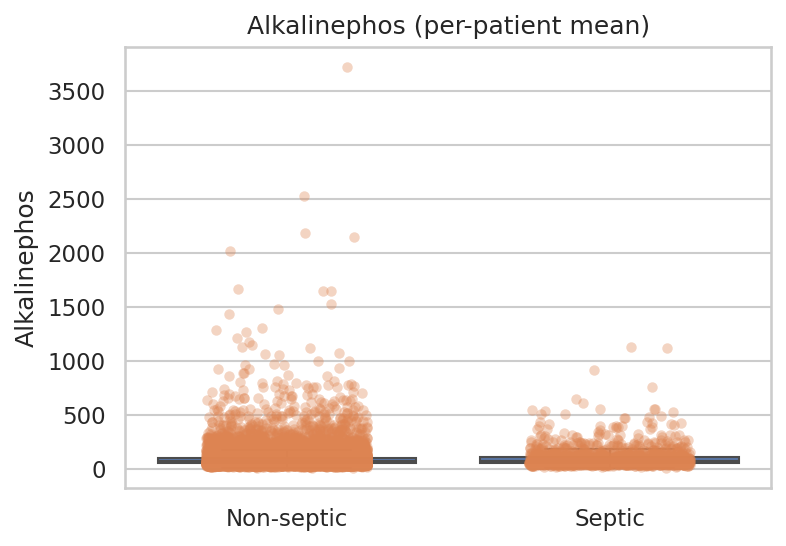

In [ ]:
# -------- Quick prevalence prints --------
n_pat = len(patient_summary)
n_sep = int(patient_summary["HasSepsis"].sum())
print(f"Patient-level prevalence → Patients: {n_pat:,} | Septic: {n_sep:,} ({n_sep/n_pat:.1%})")

# -------- Plotting dirs --------
BOX_DIR = ensure_dir(EDA_OUT / "plots_box_and_strip")
HEAT_DIR = ensure_dir(EDA_OUT / "plots_heatmaps")

# -------- Generate Box+Strip plots (seaborn) --------
for base in tqdm([c for c in num_cols if f"{c}_mean" in patient_summary.columns],
                 desc="Plots: box+strip", unit="feat", leave=False):
    col = f"{base}_mean"
    plot_df = patient_summary[[col, "HasSepsis"]].dropna().copy()
    if plot_df.empty:
        continue
    plot_df["Cohort"] = np.where(plot_df["HasSepsis"] == 1, "Septic", "Non-septic")

    fig, ax = plt.subplots(figsize=(5.4, 3.8))
    sns.boxplot(data=plot_df, x="Cohort", y=col, ax=ax, showfliers=False)
    sns.stripplot(data=plot_df, x="Cohort", y=col, ax=ax, alpha=0.35, jitter=0.25, dodge=False)
    ax.set_title(f"{base} (per-patient mean)")
    ax.set_xlabel("")
    ax.set_ylabel(base)
    save_and_show(fig, BOX_DIR / f"box_strip_{base}.png")

### **3.5. Visualizing Patient Profiles (Heatmaps)**
**What:** We are creating heatmaps of the top 20 most discriminative features for a sample of septic and non-septic patients. Each row is a patient, each column is a feature, and the color represents the value.

**Why:** Heatmaps allow us to see patterns across multiple features at once. By visualizing the "feature profiles" of patients, we can look for common patterns or signatures that are characteristic of the septic or non-septic state. Normalizing the data with a Z-score makes these patterns easier to see.

**How:** We first define a zscore_cols function to normalize the data. We select the top 20 features from our effect size table. We then create two heatmaps using matplotlib's imshow function: one for a sample of 80 non-septic patients and one for a sample of 80 septic patients.



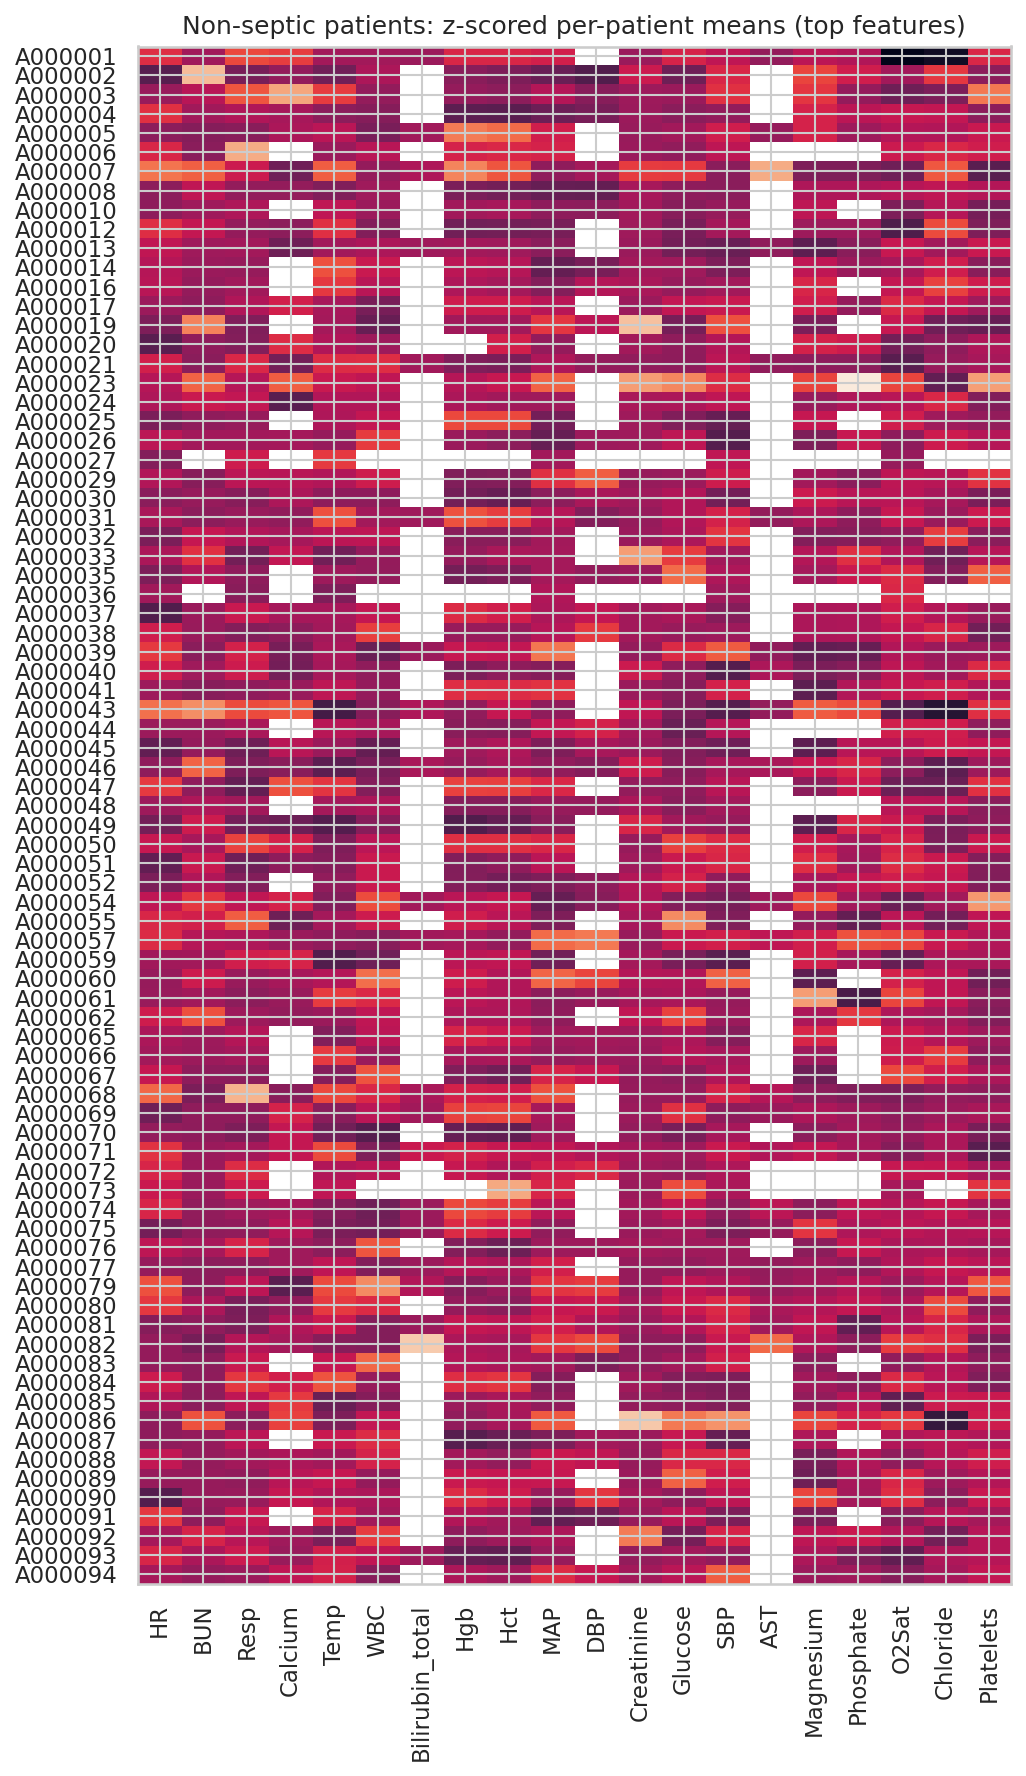

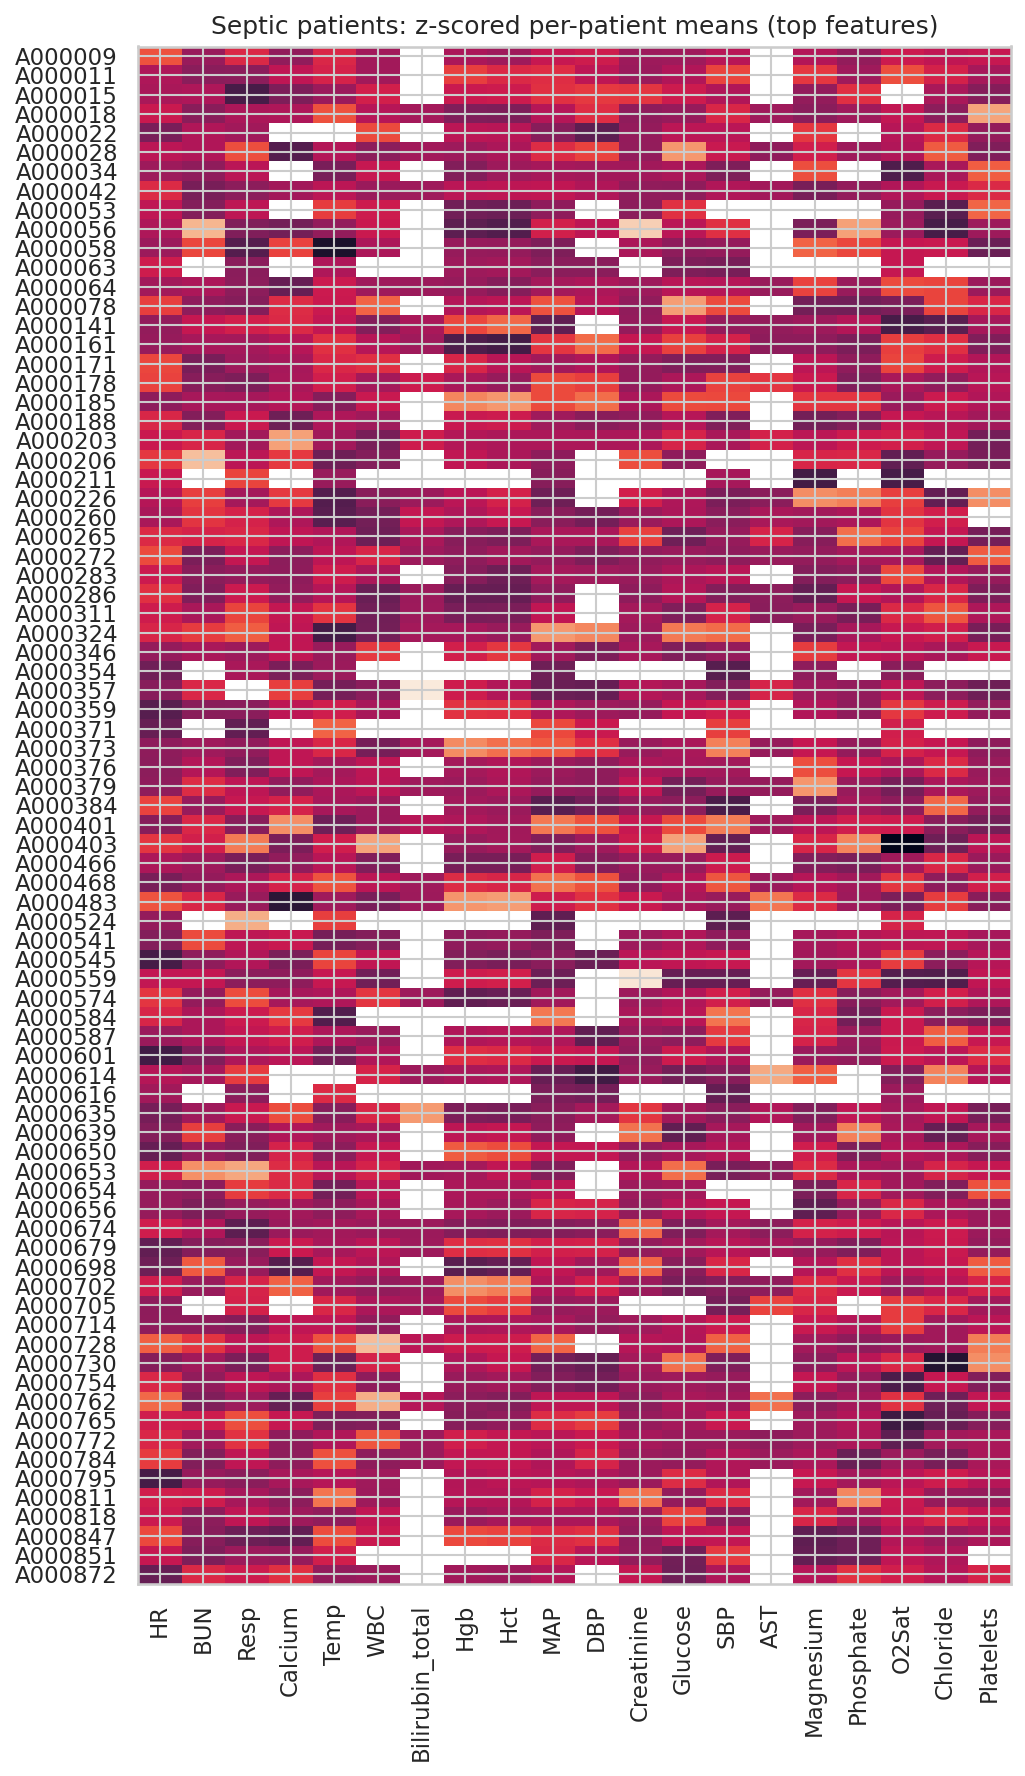


--- EDA Complete ---
Outputs saved:
 - Patient summary tables in: /content/drive/MyDrive/Sepsis Prediction/content/outputs/eda_patient_level
 - Feature effect sizes in: /content/drive/MyDrive/Sepsis Prediction/content/outputs/eda_patient_level
 - Plots saved in: /content/drive/MyDrive/Sepsis Prediction/content/outputs/eda_patient_level/plots_box_and_strip and /content/drive/MyDrive/Sepsis Prediction/content/outputs/eda_patient_level/plots_heatmaps


In [ ]:
# -------- Z-score Normalization Function --------
def zscore_cols(df_in: pd.DataFrame, cols):
    """Z-scores columns of a dataframe for heatmap visualization."""
    X = df_in[cols].to_numpy(float)
    mu = np.nanmean(X, axis=0)
    sd = np.nanstd(X, axis=0); sd[sd == 0] = 1.0 # Avoid division by zero
    return (X - mu) / sd

# -------- Select Top Features for Heatmap --------
TOPK = min(20, len(effects))
top_feats = effects.head(TOPK)["feature"].tolist()
heat_cols = [f"{f}_mean" for f in top_feats if f"{f}_mean" in patient_summary.columns]

if heat_cols:
    # --- Non-septic Heatmap ---
    ns = nonseptic.head(80)
    if len(ns) > 0:
        Z = zscore_cols(ns, heat_cols)
        fig = plt.figure(figsize=(max(6, len(heat_cols)*0.35), max(4, len(ns)*0.15)))
        plt.imshow(Z, aspect="auto", interpolation="nearest")
        plt.yticks(range(len(ns)), ns["PatientID"])
        plt.xticks(range(len(heat_cols)), [c.replace("_mean","") for c in heat_cols], rotation=90)
        plt.title("Non-septic patients: z-scored per-patient means (top features)")
        save_and_show(fig, HEAT_DIR / "heatmap_nonseptic_top.png")

    # --- Septic Heatmap ---
    sp = septic.head(80)
    if len(sp) > 0:
        Z = zscore_cols(sp, heat_cols)
        fig = plt.figure(figsize=(max(6, len(heat_cols)*0.35), max(4, len(sp)*0.15)))
        plt.imshow(Z, aspect="auto", interpolation="nearest")
        plt.yticks(range(len(sp)), sp["PatientID"])
        plt.xticks(range(len(heat_cols)), [c.replace("_mean","") for c in heat_cols], rotation=90)
        plt.title("Septic patients: z-scored per-patient means (top features)")
        save_and_show(fig, HEAT_DIR / "heatmap_septic_top.png")

print("\n--- EDA Complete ---")
print("Outputs saved:")
print(f" - Patient summary tables in: {EDA_OUT}")
print(f" - Feature effect sizes in: {EDA_OUT}")
print(f" - Plots saved in: {BOX_DIR} and {HEAT_DIR}")


## **4. Feature Engineering: Onset-Aligned Windows**
This section is the core of our feature engineering process. Instead of looking at a patient's entire stay, we now focus on a specific, clinically relevant 12-hour window for each patient. For septic patients, this window is defined as the 12 hours leading up to the onset of sepsis. For non-septic patients, it's the last 12 hours of their recorded data. From this window, we will extract powerful predictive features like means, slopes, and last-known values.

### **4.1. Configuration and Data Loading**
**What:** We are setting up our configuration for this analysis. This includes defining the window length (12 hours) and loading the cleaned time-series data.

**Why:** Centralizing parameters like WINDOW_HRS makes the analysis reproducible and easy to modify. Loading the cleaned data ensures we are building features on a reliable foundation, free from the noise and errors we handled in the previous steps.

**How:** We define key variables like WINDOW_HRS. We then use our load_any helper function to load the dataset and perform a basic preparation identical to the previous sections, ensuring data types are correct and the DataFrame is sorted by patient and time.

In [ ]:
# ---------------- Config ----------------
WINDOW_HRS = 12
EXCLUDE_ONSET_HOUR = True  # Septic windows end at onset-1 if True
COLOR_NON = "#2b8cbe"      # Non-septic (blue)
COLOR_SEP = "#de2d26"      # Septic (red)

# ---------------- Paths (prefer cleaned) ----------------
T12_OUT   = ensure_dir(Output_dir / "eda_patient_level_t12")
CLEANED   = Output_dir / "cleaning_pipeline" / "all_patients_cleaned.csv"
SRC_T12   = CLEANED if CLEANED.exists() else Source
print(f"Using dataset: {SRC_T12}")


# ---------------- Load & prep ----------------
df = load_any(SRC_T12)
assert {id, time}.issubset(df.columns), "Missing id/time columns."
df[time]   = pd.to_numeric(df[time], errors="coerce")
if Sepsis in df.columns:
    df[Sepsis] = pd.to_numeric(df[Sepsis], errors="coerce").fillna(0).astype(int)
else:
    df[Sepsis] = 0


# Keep only existing numeric feature columns
Vitals = [c for c in Vitals if c in df.columns]
Labs   = [c for c in Labs   if c in df.columns]
vars_present = Vitals + Labs
for c in vars_present:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Sort for time logic
df = df.sort_values([id, time]).reset_index(drop=True)

Using dataset: /content/drive/MyDrive/Sepsis Prediction/all_patients_data_preprocessed.csv


### **4.2. Defining the 12-Hour Window for Each Patient**
**What:** We are calculating the precise start and end hour for the 12-hour analysis window for every patient in the dataset.

**Why:** This step transforms our problem from analyzing a variable-length time-series to comparing fixed-length, clinically-aligned feature vectors. For septic patients, this window captures the critical period of physiological decline just before diagnosis. For non-septic patients, it captures their most recent state.

**How:** We first find the sepsis onset_hour for each septic patient.

The WindowEnd is set to the onset_hour - 1 for septic patients (to avoid data leakage from the exact moment of diagnosis) and the last_hour of their stay for non-septic patients.

The WindowStart is calculated as WindowEnd - 11 hours, ensuring an inclusive 12-hour period. We also clamp it to ensure it doesn't go below a patient's first recorded hour.

In [ ]:
# ---------------- Build per-patient windows ----------------
# Get each patient's first and last recorded hour
span = df.groupby(id, sort=False)[time].agg(first_hour="min", last_hour="max")

# Find the first hour of Sepsis==1 for septic patients
onset_tbl = df.loc[df[Sepsis] == 1, [id, time]].groupby(id, sort=False)[time].min().rename("onset_hour")
pw = span.join(onset_tbl, how="left").reset_index().rename(columns={id: "PatientID"})

# Create a patient-level 'HasSepsis' flag
has_sepsis = df.groupby(id, sort=False)[Sepsis].max().astype(int).rename("HasSepsis")
pw = pw.join(has_sepsis, on="PatientID")

# Define the WindowEnd based on sepsis status
if EXCLUDE_ONSET_HOUR:
    pw["WindowEnd"] = np.where(pw["HasSepsis"] == 1, pw["onset_hour"] - 1, pw["last_hour"])
else:
    pw["WindowEnd"] = np.where(pw["HasSepsis"] == 1, pw["onset_hour"], pw["last_hour"])

# Define the WindowStart to create a 12-hour period
pw["WindowStart"] = pw["WindowEnd"] - (WINDOW_HRS - 1)
pw["WindowStart"] = np.maximum(pw["WindowStart"], pw["first_hour"]) # Clamp to first measurement

# ---------------- Filter time-series data to in-window rows ----------------
# Merge the calculated window boundaries back to the main time-series dataframe
tmp = df.merge(pw[["PatientID","WindowStart","WindowEnd","HasSepsis"]],
               left_on=id, right_on="PatientID", how="left")

# Create a boolean flag for rows that fall within each patient's window
tmp["in_window"] = (tmp[time] >= tmp["WindowStart"]) & (tmp[time] <= tmp["WindowEnd"])

# Create a new dataframe 'inwin' containing ONLY the rows within these windows
inwin = tmp[tmp["in_window"]].copy()

### **4.3. Extracting Features from the Window**
**What:** We are calculating three types of features from the data inside each patient's 12-hour window: the mean value, the last recorded value, and the slope (rate of change) for each clinical variable.

**Why:** These three feature types capture different aspects of a patient's state.

*Mean:* Represents the patient's average condition during the window.

*Last:* Represents the patient's most recent state just before the window ends.

*Slope:* Captures the trend of the data. A rising heart rate (positive slope) is a much stronger warning sign than a high but stable heart rate.

**How:** We group the inwin data by patient. For each patient and each variable, we apply vectorized operations for .mean() and custom .apply() functions to find the last_non_null_series value and to calculate the slope_per_hour_block using linear regression. These new features are then merged into our patient-level summary table (pw).

In [ ]:
# ---------------- Feature Extraction Helper Functions ----------------
def last_non_null_series(s: pd.Series) -> float:
    """Efficiently finds the last valid (non-null) value in a series."""
    s = s.dropna()
    return float(s.iloc[-1]) if len(s) else np.nan

def slope_per_hour_block(t_arr: np.ndarray, y_arr: np.ndarray) -> float:
    """Calculates the rate of change (slope) using linear regression (polyfit)."""
    mask = ~np.isnan(t_arr) & ~np.isnan(y_arr)
    if mask.sum() < 2:
        return np.nan
    t = t_arr[mask].astype(float)
    y = y_arr[mask].astype(float)
    dt = t.max() - t.min()
    if dt <= 0: return np.nan
    try:
        # Use polyfit for a robust linear regression
        return float(np.polyfit(t, y, 1)[0])
    except Exception:
        # Fallback for numerical instability
        return float((y[-1] - y[0]) / (t[-1] - t[0]))


# ---------------- Calculate MEAN features ----------------
if not inwin.empty and vars_present:
    means_tbl = inwin.groupby("PatientID", sort=False)[vars_present].mean()
    means_tbl.columns = [f"{c}_mean_win" for c in means_tbl.columns]
    pw = pw.merge(means_tbl, left_on="PatientID", right_index=True, how="left")

# ---------------- Calculate LAST VALUE features (iterative) ----------------
if not inwin.empty:
    for v in tqdm(vars_present, desc="Compute last values", unit="feat", leave=False):
        last_vals = inwin.groupby("PatientID", sort=False)[v].apply(last_non_null_series)
        pw[f"{v}_last"] = pw["PatientID"].map(last_vals)

# ---------------- Calculate SLOPE features (iterative, vitals only) ----------------
vars_for_slope = [v for v in Vitals if v in vars_present]
if not inwin.empty and vars_for_slope:
    for v in tqdm(vars_for_slope, desc="Compute slopes", unit="feat", leave=False):
        # Drop rows where the variable is null to speed up grouping
        s = inwin[["PatientID", time, v]].dropna(subset=[v])
        if s.empty:
            pw[f"{v}_slope_per_hr"] = np.nan
            continue
        # Apply the slope calculation per patient
        sl_ser = s.groupby("PatientID", sort=False).apply(
            lambda g: slope_per_hour_block(g[time].to_numpy(), g[v].to_numpy())
        )
        pw[f"{v}_slope_per_hr"] = pw["PatientID"].map(sl_ser)

# ---------------- Save the final feature table ----------------
enriched_csv = T12_OUT / "patient_windows_t12_features.csv"
pw.to_csv(enriched_csv, index=False)
print("Saved enriched window features →", enriched_csv)

Saved enriched window features → /content/drive/MyDrive/Sepsis Prediction/content/outputs/eda_patient_level_t12/patient_windows_t12_features.csv


### **4.4. Analyzing and Visualizing Feature Importance**
**What:** We are now using the features we just created to analyze the differences between septic and non-septic patients. We calculate the effect size (Cohen's d) for each feature and create plots to visualize the most discriminative ones.

**Why:** This step validates our feature engineering. By identifying features with large effect sizes (e.g., a large difference in the slope of Lactate), we confirm that our approach is capturing clinically meaningful signals. The visualizations make these findings easy to understand and communicate.

**How:**

*Effect Size:* We reuse the cohens_d function to calculate the standardized difference between the two cohorts for each new feature (_mean_win, _last, _slope_per_hr).

*Histograms:* We plot histograms of the WindowEnd hour to confirm that our windowing logic is working as expected.

*Strip Plots:* We create horizontal strip plots to visualize the distribution of individual patient values for each feature, clearly showing the separation (or lack thereof) between the groups.

*Bar Charts:* We generate bar charts that rank the features by their effect size, providing a clear summary of the most important predictors of sepsis in our 12-hour window.

Saved effects tables to: /content/drive/MyDrive/Sepsis Prediction/content/outputs/eda_patient_level_t12


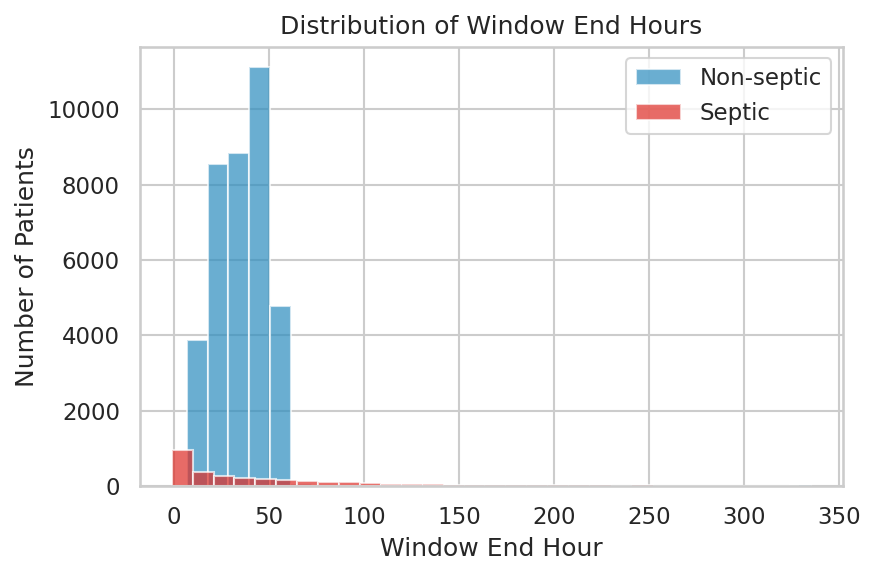

Plots: strips:   0%|          | 0/23 [00:00<?, ?feat/s]

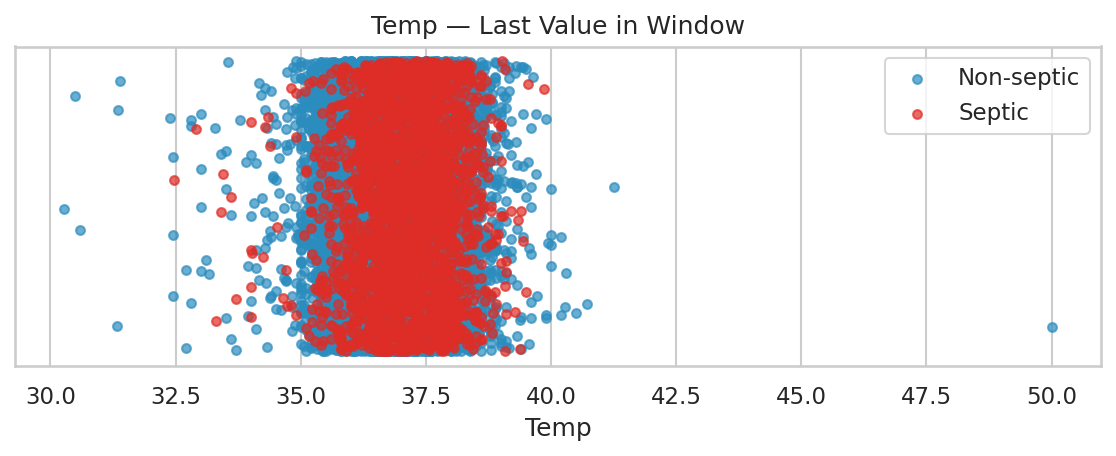

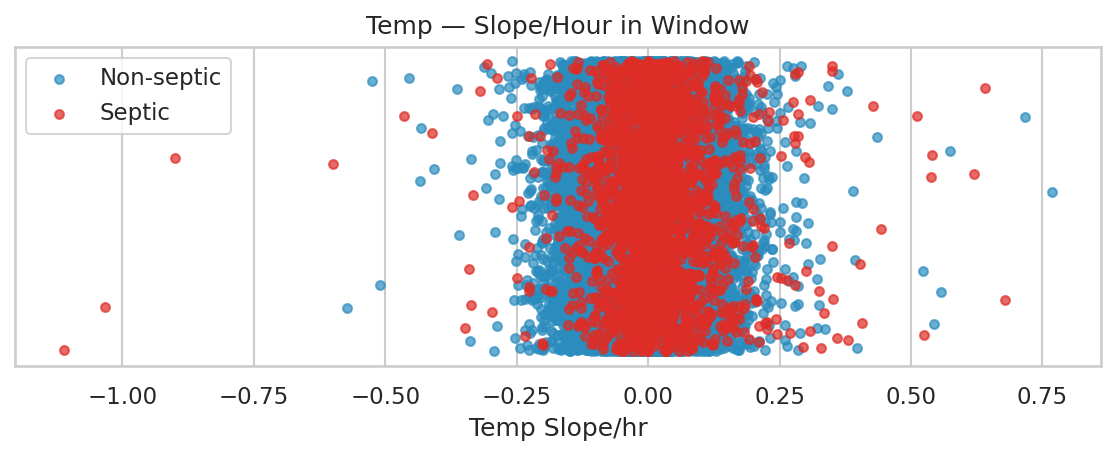

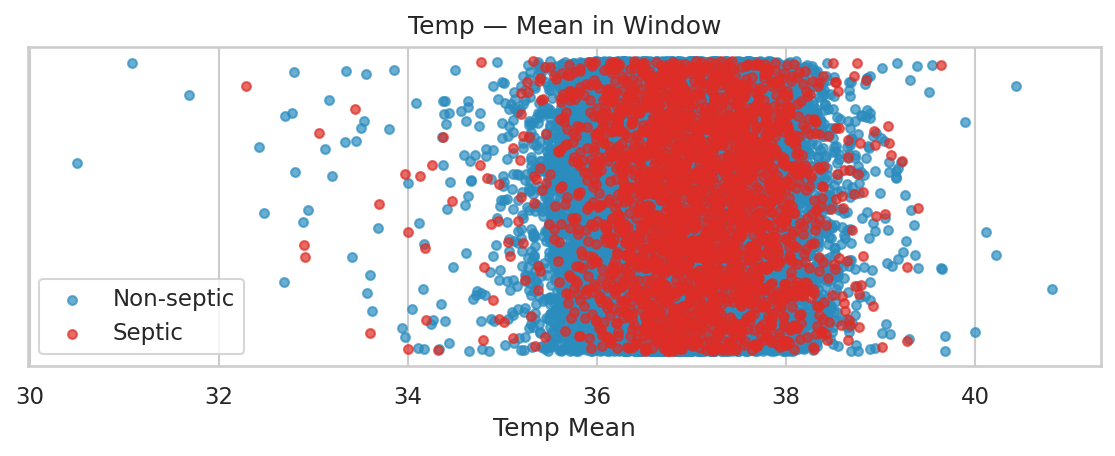

Plots: strips:   4%|▍         | 1/23 [00:08<03:03,  8.32s/feat]

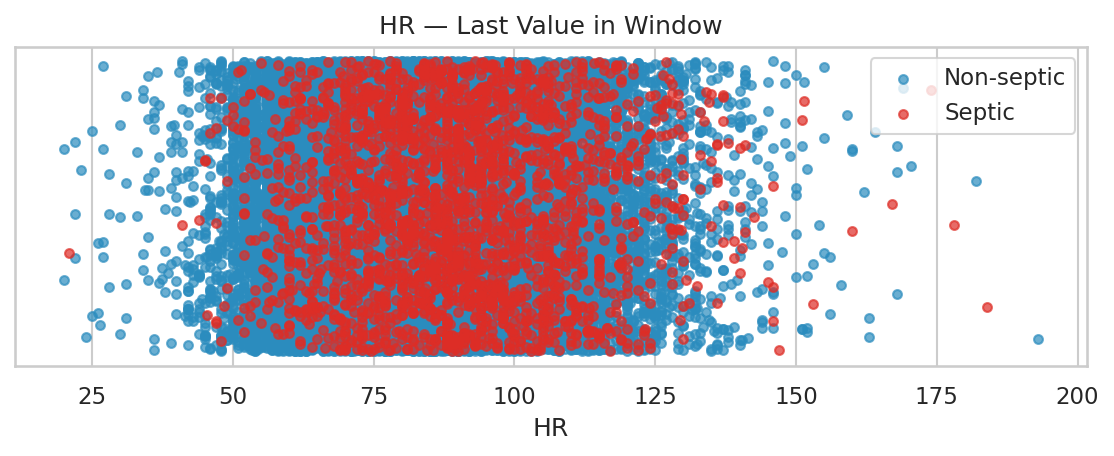

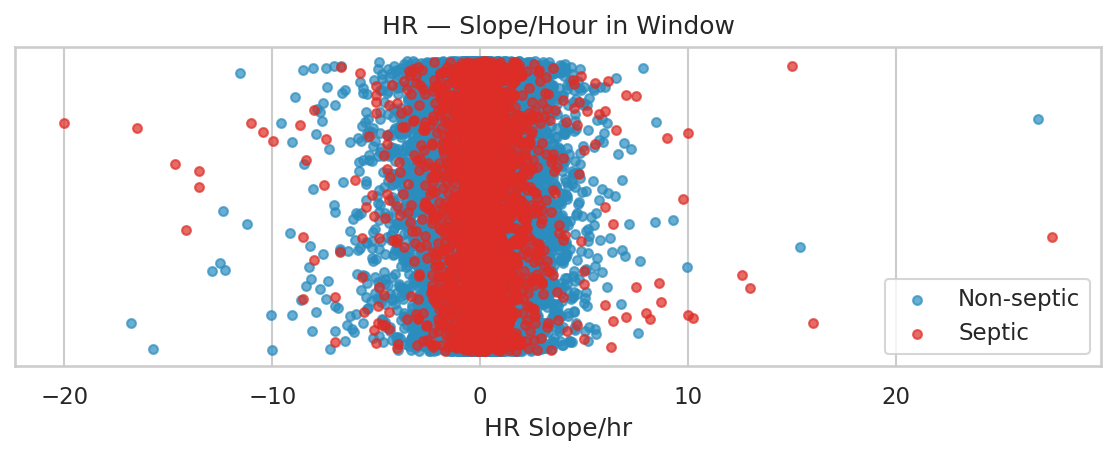

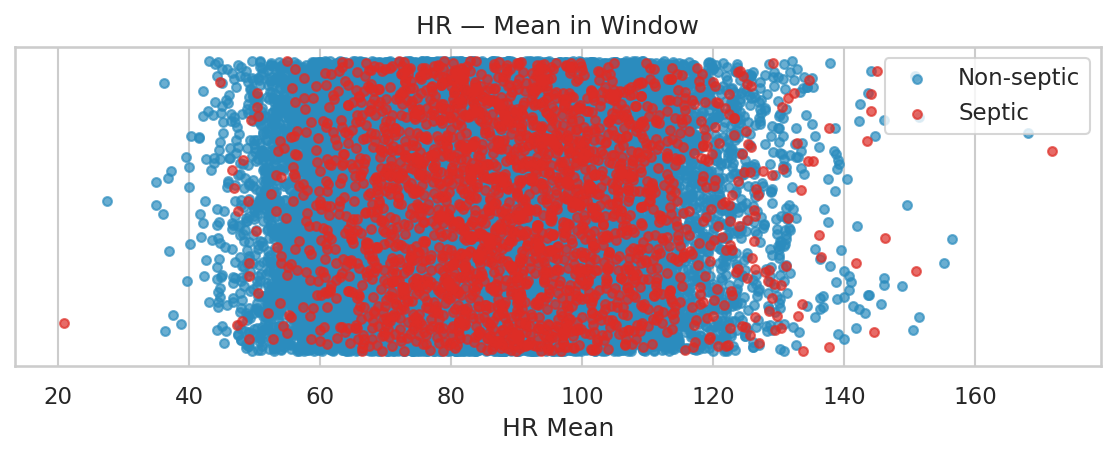

Plots: strips:   9%|▊         | 2/23 [00:18<03:14,  9.25s/feat]

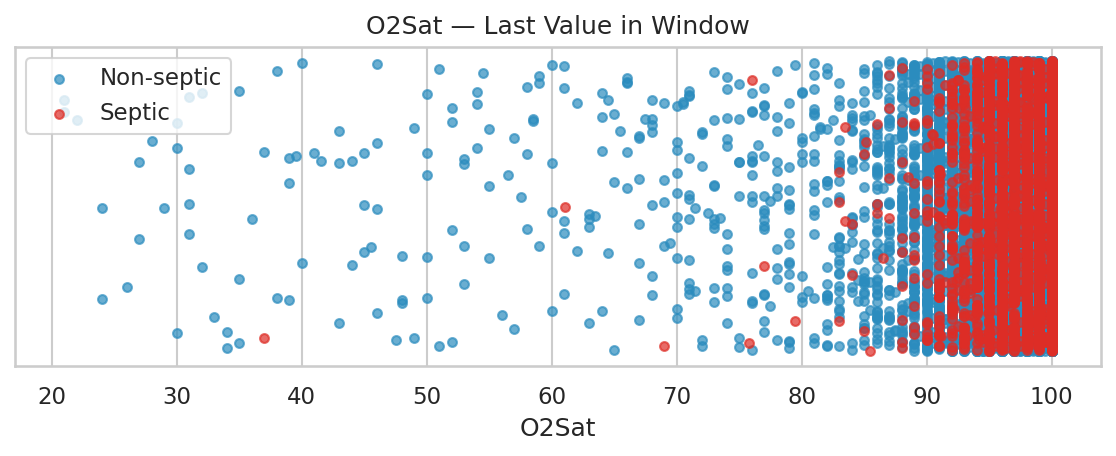

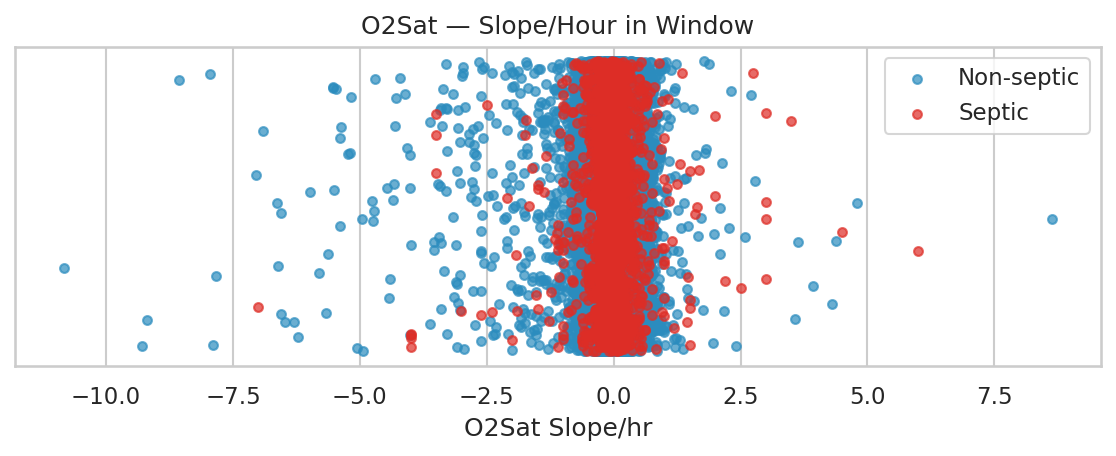

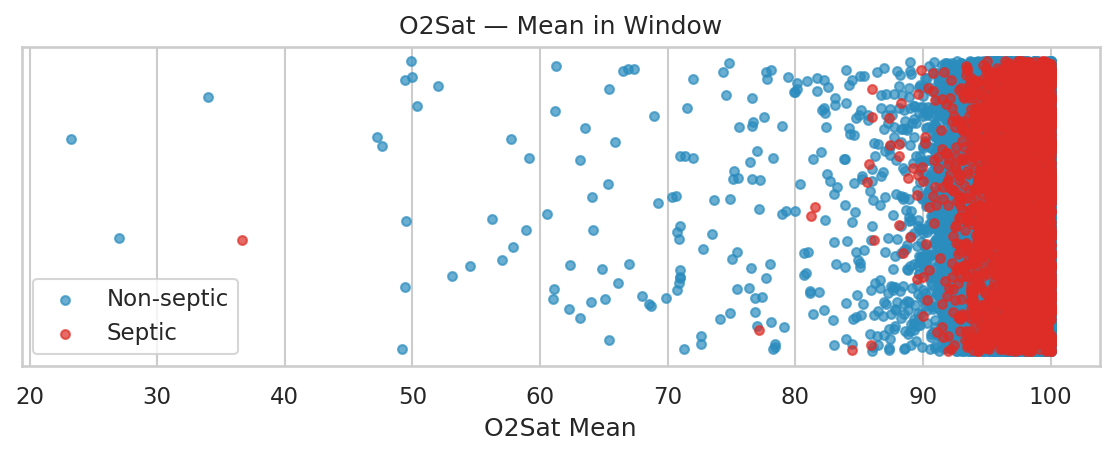

Plots: strips:  13%|█▎        | 3/23 [00:25<02:50,  8.50s/feat]

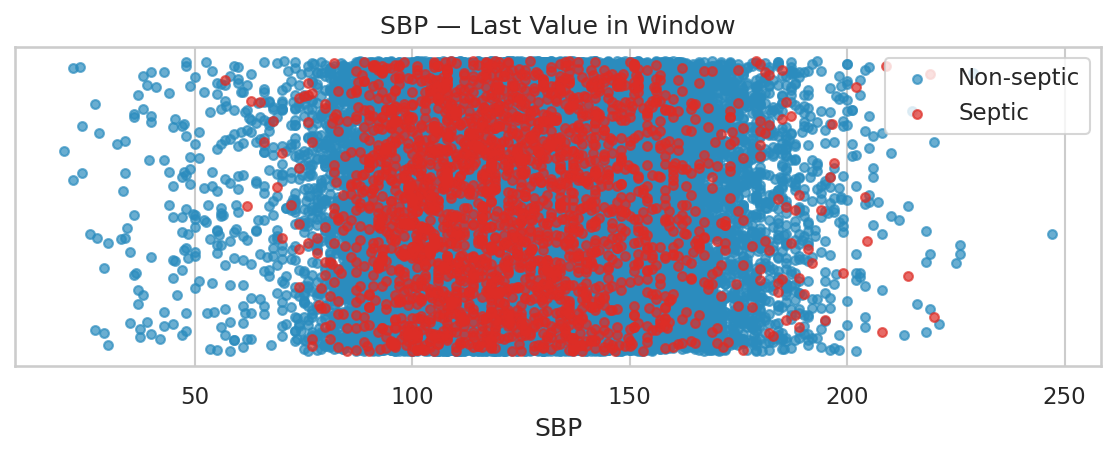

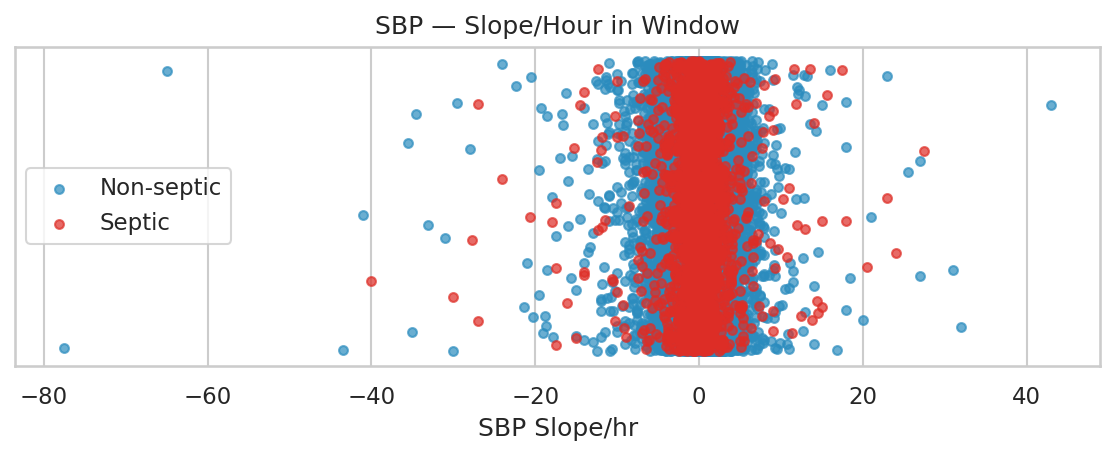

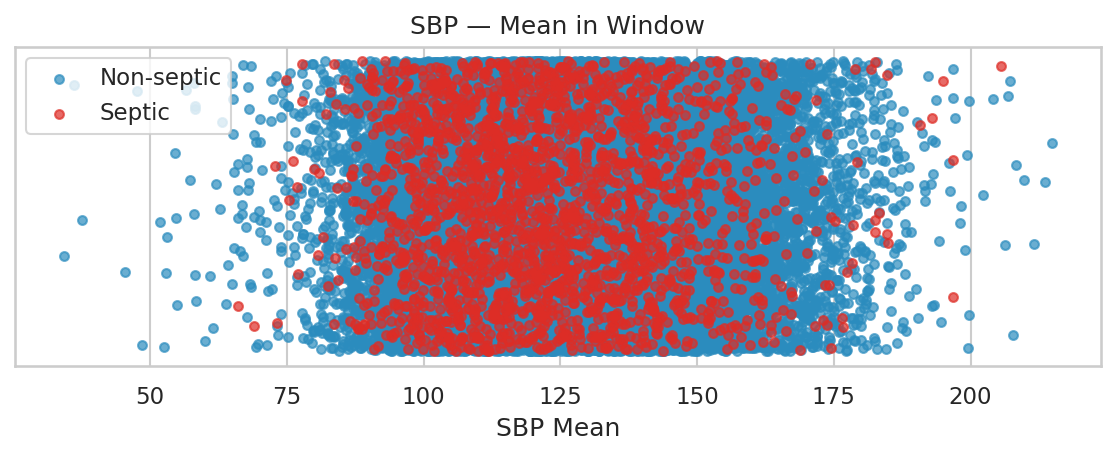

Plots: strips:  17%|█▋        | 4/23 [00:34<02:46,  8.75s/feat]

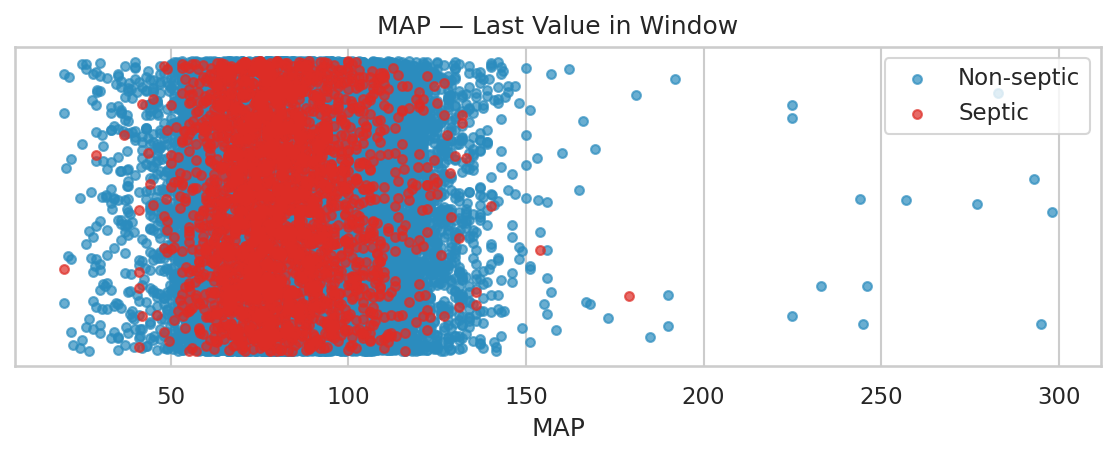

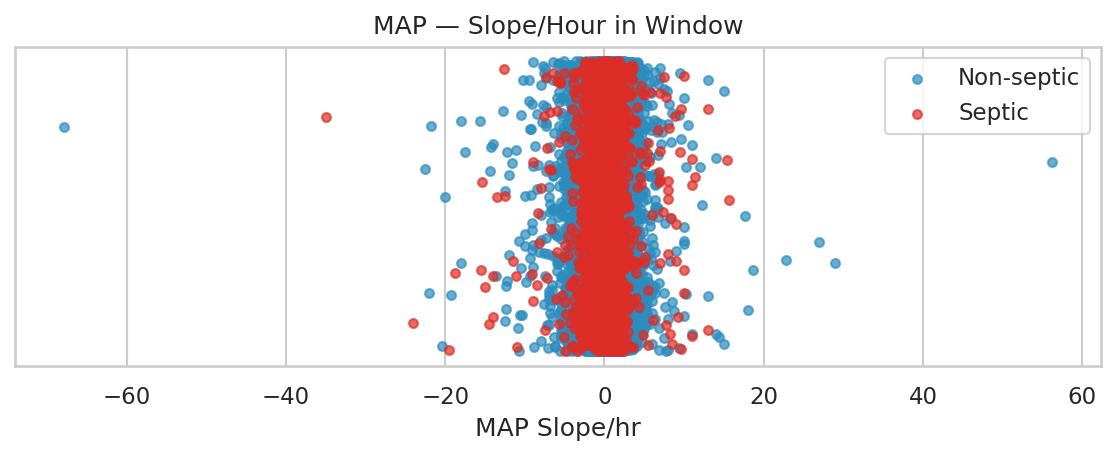

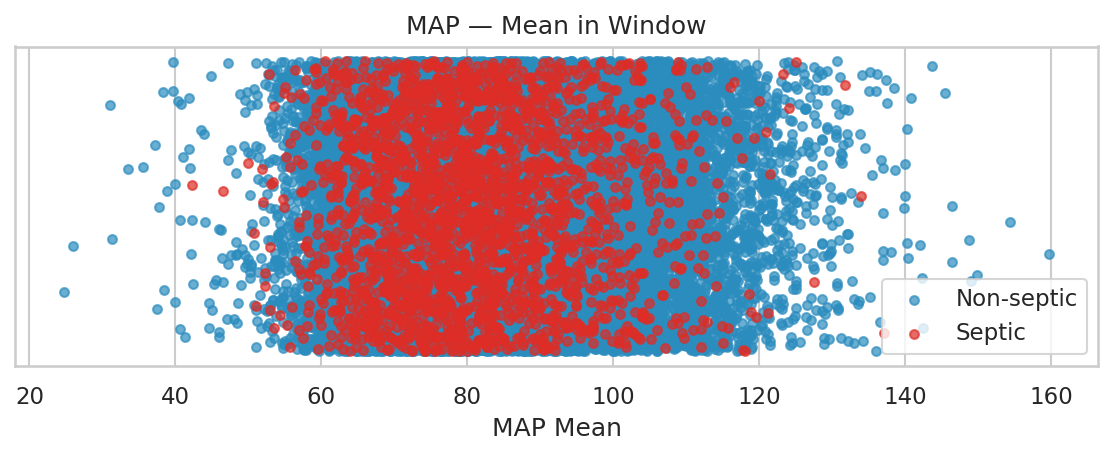

Plots: strips:  22%|██▏       | 5/23 [00:43<02:37,  8.74s/feat]

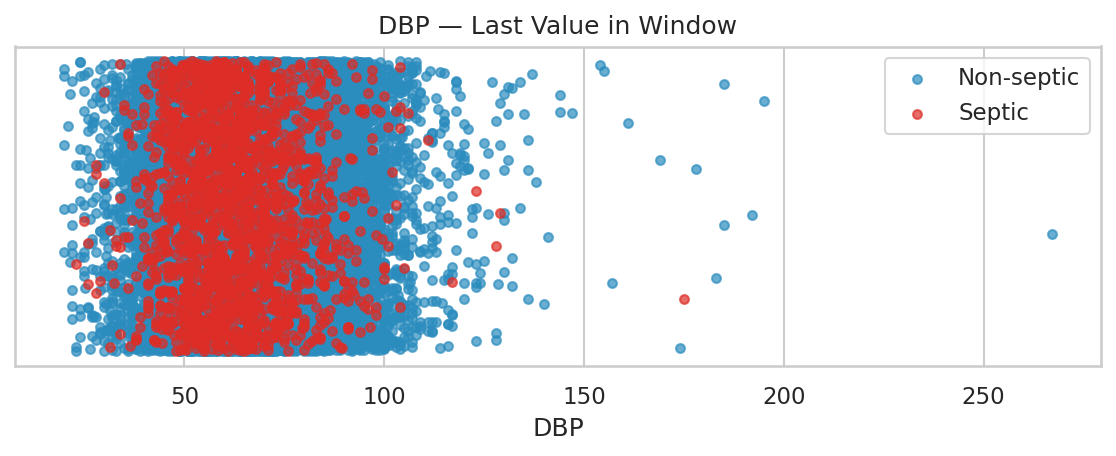

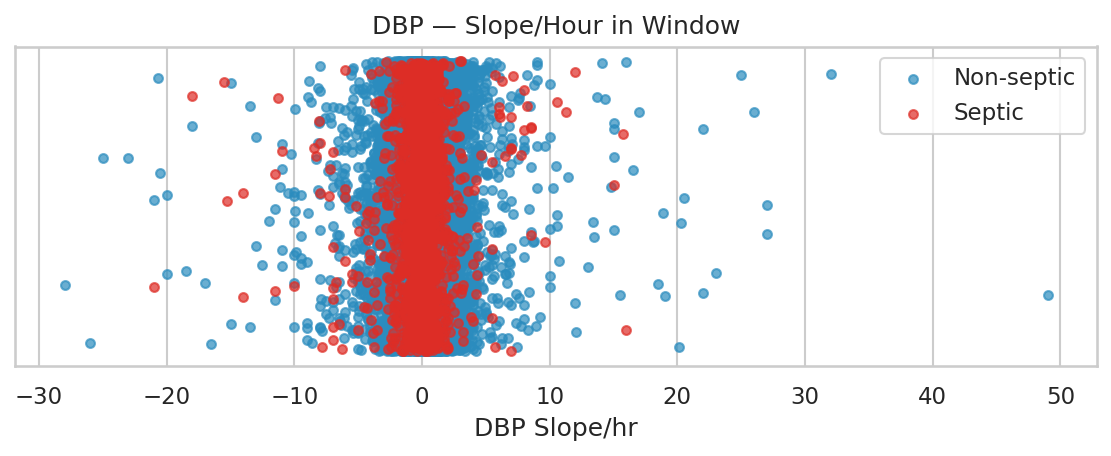

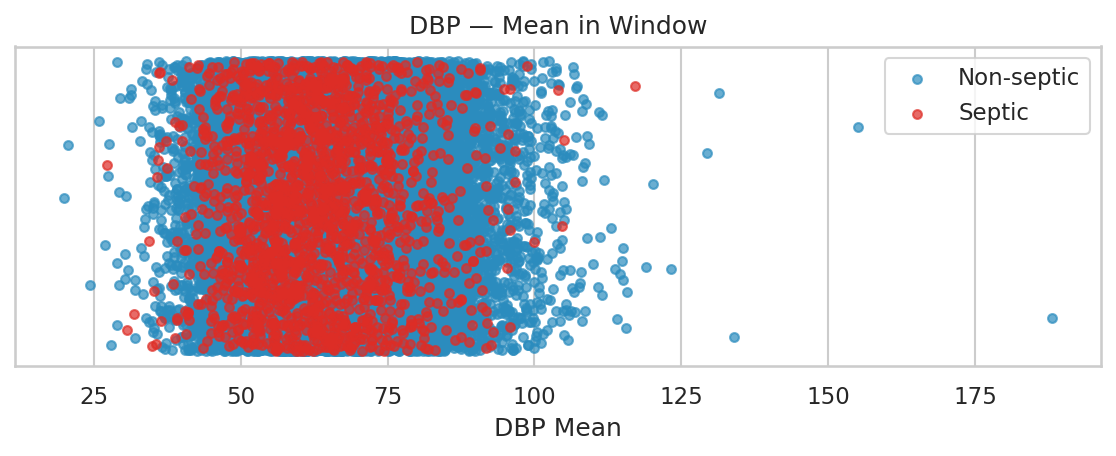

Plots: strips:  26%|██▌       | 6/23 [00:49<02:12,  7.79s/feat]

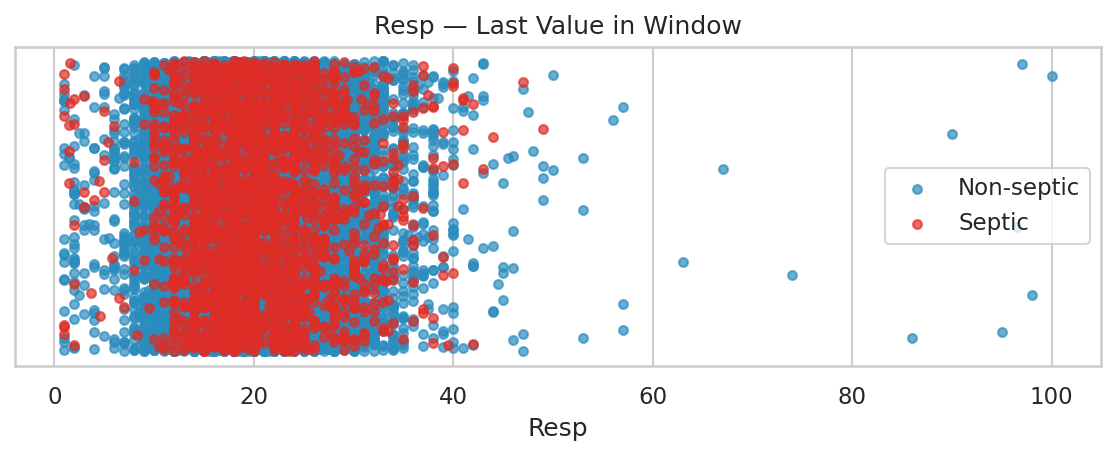

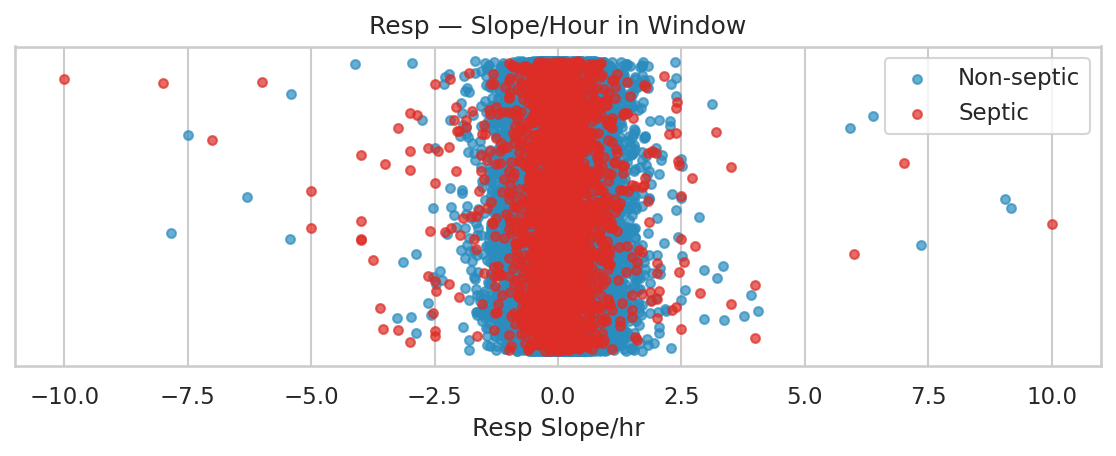

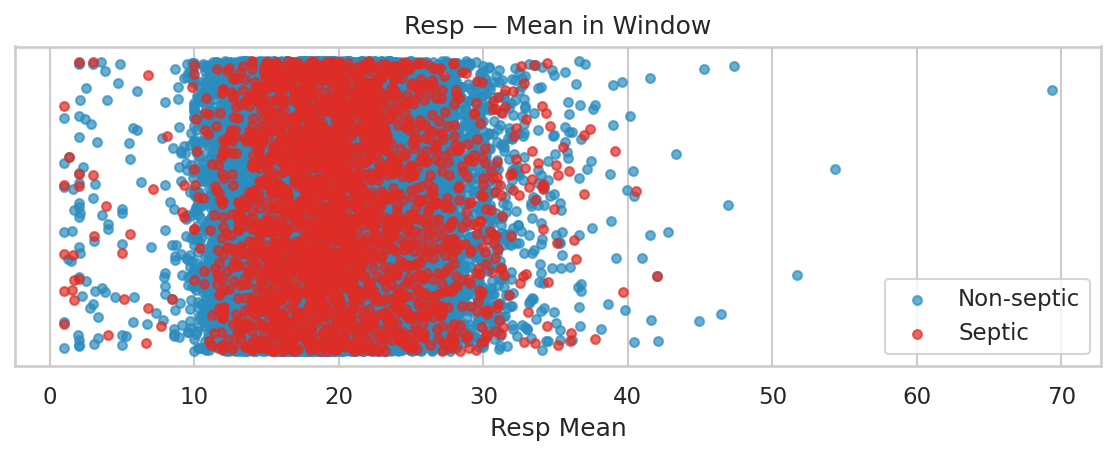

Plots: strips:  30%|███       | 7/23 [00:57<02:04,  7.78s/feat]

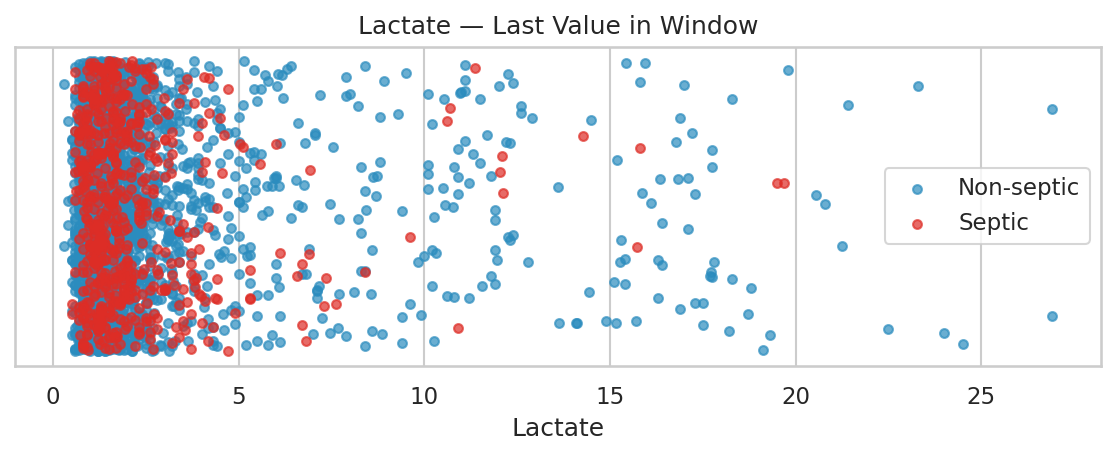

AttributeError: 'NoneType' object has no attribute 'dropna'

<Figure size 1140x480 with 0 Axes>

In [ ]:
# ---------------- Calculate Effect Sizes (Cohen's d) ----------------
sep = pw[pw["HasSepsis"] == 1].copy()
non = pw[pw["HasSepsis"] == 0].copy()

vars_ready = [v for v in vars_present if f"{v}_mean_win" in pw.columns]

eff_rows = []
for v in tqdm(vars_ready, desc="Computing effect sizes", unit="feat", leave=False):
    d_last  = cohens_d(sep.get(f"{v}_last", pd.Series()), non.get(f"{v}_last", pd.Series()))
    d_slope = cohens_d(sep.get(f"{v}_slope_per_hr", pd.Series()), non.get(f"{v}_slope_per_hr", pd.Series()))
    d_mean  = cohens_d(sep.get(f"{v}_mean_win", pd.Series()), non.get(f"{v}_mean_win", pd.Series()))
    eff_rows.append([v, d_last, d_slope, d_mean])

eff_df = pd.DataFrame(eff_rows, columns=["feature","cohens_d_last","cohens_d_slope","cohens_d_mean"]).set_index("feature")
eff_df.to_csv(T12_OUT / "effects_all_features.csv")
print("Saved effects tables to:", T12_OUT)


# ---------------- Plotting and Visualization ----------------
sns.set_theme(context="notebook", style="whitegrid")

# Plot 1: Histogram of WindowEnd hours
hist_dir = ensure_dir(T12_OUT / "histograms")
fig = plt.figure(figsize=(6,4))
plt.hist(non["WindowEnd"].dropna(), bins=30, alpha=0.7, label="Non-septic", color=COLOR_NON)
plt.hist(sep["WindowEnd"].dropna(),  bins=30, alpha=0.7, label="Septic", color=COLOR_SEP)
plt.xlabel("Window End Hour"); plt.ylabel("Number of Patients")
plt.title("Distribution of Window End Hours")
plt.legend()
save_and_show(fig, hist_dir / "window_end_hist.png")

# Plot 2: Horizontal strip plots
strip_dir_last  = ensure_dir(T12_OUT / "hstrip_last")
strip_dir_slope = ensure_dir(T12_OUT / "hstrip_slope")
strip_dir_mean  = ensure_dir(T12_OUT / "hstrip_mean")

rng = np.random.default_rng(7)
def hstrip(x_non, x_sep, xlabel, title, outpath: Path):
    # This function creates a horizontal scatter plot to show distributions
    fig = plt.figure(figsize=(7.6, 3.2))
    plt.scatter(x_non.dropna(), rng.uniform(-0.08, 0.08, size=len(x_non.dropna())), s=18, alpha=0.7, color=COLOR_NON, label="Non-septic")
    plt.scatter(x_sep.dropna(), rng.uniform(-0.08, 0.08, size=len(x_sep.dropna())), s=18, alpha=0.7, color=COLOR_SEP, label="Septic")
    plt.yticks([]); plt.xlabel(xlabel); plt.title(title); plt.legend()
    save_and_show(fig, outpath)

for v in tqdm(vars_ready, desc="Plots: strips", unit="feat", leave=False):
    hstrip(non.get(f"{v}_last"), sep.get(f"{v}_last"), xlabel=v, title=f"{v} — Last Value in Window", outpath=strip_dir_last / f"hstrip_last_{v}.png")
    hstrip(non.get(f"{v}_slope_per_hr"), sep.get(f"{v}_slope_per_hr"), xlabel=f"{v} Slope/hr", title=f"{v} — Slope/Hour in Window", outpath=strip_dir_slope / f"hstrip_slope_{v}.png")
    hstrip(non.get(f"{v}_mean_win"), sep.get(f"{v}_mean_win"), xlabel=f"{v} Mean", title=f"{v} — Mean in Window", outpath=strip_dir_mean / f"hstrip_mean_{v}.png")


# Plot 3: Bar charts of top features by effect size
bar_dir = T12_OUT
def bar_topk(eff_series: pd.Series, title: str, outname: str, k: int = 15):
    # This function plots the top k features ranked by effect size
    top = eff_series.reindex(eff_series.abs().sort_values(ascending=False).index)[:k]
    fig = plt.figure(figsize=(8, max(3.5, 0.35*len(top))))
    plt.barh(top.index, top.values)
    plt.gca().invert_yaxis()
    plt.xlabel("Cohen's d (Effect Size)")
    plt.title(title)
    save_and_show(fig, bar_dir / outname)

bar_topk(eff_df["cohens_d_mean"],  "Top Features by |d| — Mean in Window", "bar_top_mean.png")
bar_topk(eff_df["cohens_d_last"],  "Top Features by |d| — Last Value in Window", "bar_top_last.png")
bar_topk(eff_df["cohens_d_slope"], "Top Features by |d| — Slope/Hour in Window","bar_top_slope.png")

print("\nDone. All outputs are in:", T12_OUT)

## 5. Advanced EDA: Trajectories, Trends, and Statistical Comparisons
This section performs a deep dive into the cleaned, time-series data. We will move beyond simple patient-level averages to explore several different views of the data. The analysis includes:

**Individual Patient Trajectories:** Visualizing the clinical course of a sample of patients.

**Aggregate Trends:** Looking at how vital signs evolve over time for the entire septic vs. non-septic populations.

**Correlations:** Understanding the relationships between different clinical variables.

**Statistical Testing:** Rigorously testing for significant differences between the cohorts at various time points.



### **5.1. Setup and Configuration**
**What:** We are defining the output directories, setting configuration parameters for our analysis, and loading the cleaned dataset.

**Why:** This initial setup organizes our work. By defining specific feature lists for different plots (e.g., TREND_FEATURES) and setting constants like N_PATIENTS_PER_GROUP, we make the code modular and easy to interpret. Loading the fully cleaned dataset ensures all subsequent analyses are performed on high-quality data.

**How:** We use the ensure_dir function to create a structured hierarchy of output folders. We define Python lists and variables for configuration. Finally, we load the data, confirm the presence of essential columns (PatientID, Hour, SepsisLabel), and create a "frozen" copy (DF) to prevent accidental modifications.

In [ ]:
# ---------- Config / Safety ----------
# Set a seed for reproducibility of random sampling
SEED = 42
random.seed(SEED); np.random.seed(SEED)

# Feature subsets (use only those present in the data)
DIST_FEATURES   = ["HR","SBP","MAP","Resp","Temp","O2Sat","Lactate","WBC","Creatinine"]
TREND_FEATURES  = ["HR","MAP","Resp","Temp","O2Sat","Lactate"]
ONSET_FEATURES  = ["HR","MAP","Resp","Temp","O2Sat","Lactate"]
XCORR_PAIRS     = [("Resp","O2Sat"), ("HR","Temp"), ("MAP","HR")]
N_PATIENTS_PER_GROUP = 8         # Trajectories to plot per cohort
ONSET_WINDOW_HRS     = 24        # Relative window for onset-aligned plots: [-24, +24]
MAX_ROWS_CORR        = 200_000   # Sample rows for correlation heatmap
MAX_LAG              = 12        # Cross-correlation lags

# Colors for consistent plotting
COLOR_NON = "#2b8cbe"  # Blue
COLOR_SEP = "#de2d26"  # Red

# ---------- Output Directories ----------
PART3_DIR = ensure_dir(Output_dir / "part3_eda")
SUBDIRS = {
    "trajectories":      ensure_dir(PART3_DIR / "patient_trajectories"),
    "distributions":     ensure_dir(PART3_DIR / "distributions"),
    "temporal_trends":   ensure_dir(PART3_DIR / "temporal_trends"),
    "onset_trends":      ensure_dir(PART3_DIR / "onset_aligned_trends"),
    "correlations":      ensure_dir(PART3_DIR / "correlations"),
    "temporal_xcorr":    ensure_dir(PART3_DIR / "temporal_xcorr"),
    "cohort_comparisons":ensure_dir(PART3_DIR / "cohort_comparisons"),
    "three_way":         ensure_dir(PART3_DIR / "three_way_presepsis"),
}

# ---------- Load Data ----------
CLEANED = Output_dir / "cleaning_pipeline" / "all_patients_cleaned.csv"
SRC3 = CLEANED if CLEANED.exists() else Source
print(f"[Sec 5.1] Using dataset: {SRC3}")

df = load_any(SRC3)

# ---- Prepare Labels and Data Types ----
Sepsis = "SepsisLabel"
assert {id, time, Sepsis}.issubset(df.columns), f"Missing required columns in {SRC3}"
df[Sepsis] = pd.to_numeric(df[Sepsis], errors="coerce").fillna(0).clip(0,1).astype(int)
df[time] = pd.to_numeric(df[time], errors="coerce")
for c in (Vitals + Labs):
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")
df = df.sort_values([id, time]).reset_index(drop=True)

# ---- Finalize Feature Lists ----
Vitals = [c for c in Vitals if c in df.columns]
Labs   = [c for c in Labs   if c in df.columns]
vars_present = Vitals + Labs

# Create a stable copy for all subsequent steps
DF = df.copy()

# ---- Create Patient-Level Metadata ----
has_sepsis = DF.groupby(id, sort=False)[Sepsis].max().astype(int).rename("HasSepsis")
span = DF.groupby(id, sort=False)[time].agg(first_hour="min", last_hour="max")
onset_tbl = DF.loc[DF[Sepsis]==1, [id, time]].groupby(id, sort=False)[time].min().rename("onset_hour")
meta_pat = span.join(onset_tbl, how="left").join(has_sepsis, how="left").reset_index().rename(columns={id:"PatientID"})

# ---- Helper Functions ----
def flatten_cols_inplace(df_in: pd.DataFrame):
    """Flattens a multi-index column header after a groupby.agg operation."""
    if isinstance(df_in.columns, pd.MultiIndex):
        df_in.columns = [f"{a}_{b}".strip("_") for a, b in df_in.columns]

### **5.2. Individual Patient Trajectories**
**What:** We are plotting the time-series data for a small, random sample of individual patients from both the septic and non-septic cohorts.

**Why:** While aggregate trends are useful, they can hide significant individual variability. Viewing the raw trajectories helps us build intuition about the data, see how noisy the signals are, and observe the clinical course of real patients.

**How:** We first sample a few PatientIDs from each cohort. Then, we loop through these IDs, select the corresponding patient's data from the main DataFrame, and pass it to a plot_patient_trajectory helper function that generates and saves a multi-panel plot of their vital signs and labs over time.

In [ ]:
def plot_patient_trajectory(g: pd.DataFrame, features, title, outpath: Path):
    """Generates a multi-panel plot for a single patient's time-series data."""
    feats = [f for f in features if f in g.columns and g[f].notna().any()]
    if g.empty or not feats: return
    n = len(feats); ncols = 3; nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 3.0*nrows), sharex=True)
    axes = np.ravel(axes)
    for ax, f in zip(axes, feats):
        ax.plot(g[time], g[f], linewidth=1.2, color=COLOR_SEP if "Septic" in title else COLOR_NON)
        ax.set_title(f); ax.grid(True, alpha=0.3)
    for ax in axes[len(feats):]: ax.axis("off") # Turn off unused subplots
    fig.suptitle(title, y=0.98)
    save_and_show(fig, outpath)

# --- Sample Patients and Plot ---
pids_sep = meta_pat.loc[meta_pat["HasSepsis"]==1, "PatientID"].tolist()
pids_non = meta_pat.loc[meta_pat["HasSepsis"]==0, "PatientID"].tolist()
sample_sep = random.sample(pids_sep, k=min(N_PATIENTS_PER_GROUP, len(pids_sep)))
sample_non = random.sample(pids_non, k=min(N_PATIENTS_PER_GROUP, len(pids_non)))
TRAJ_FEATURES = [f for f in ["HR","SBP","MAP","Resp","Temp","O2Sat","Lactate","WBC","Creatinine"] if f in vars_present]

print(f"[Sec 5.2] Plotting trajectories | Septic: {len(sample_sep)} patients, Non-septic: {len(sample_non)} patients")
for pid in tqdm(sample_sep, desc="Plotting Septic Trajectories", unit="patient", leave=False):
    g = DF.loc[DF[id]==pid, [time]+TRAJ_FEATURES]
    plot_patient_trajectory(g, TRAJ_FEATURES, f"Patient {pid} (Septic)", SUBDIRS["trajectories"]/f"traj_septic_{pid}.png")

for pid in tqdm(sample_non, desc="Plotting Non-Septic Trajectories", unit="patient", leave=False):
    g = DF.loc[DF[id]==pid, [time]+TRAJ_FEATURES]
    plot_patient_trajectory(g, TRAJ_FEATURES, f"Patient {pid} (Non-septic)", SUBDIRS["trajectories"]/f"traj_non_{pid}.png")

### **5.3. Aggregate Trends and Distributions**
**What:** We are analyzing the data at a population level. This involves plotting the distribution (histograms and KDEs) of key features for each cohort and plotting the average trend of these features over the course of the ICU stay.

**Why:** This provides a "bird's-eye view" of the data. Distribution plots show us the overall differences in values between the two groups. Aggregate time-trends show us if and when the average septic patient begins to diverge from the average non-septic patient. We also create "onset-aligned" plots for the septic cohort to see the average trajectory specifically around the time of sepsis diagnosis.

**How:**

*Distributions:* For each feature, we use seaborn.histplot and seaborn.kdeplot with hue="SepsisLabel" to automatically generate comparative plots.

*Temporal Trends:* We group the data by Hour and SepsisLabel and calculate the mean and median. We then plot these aggregate values against the ICU hour.

*Onset-Aligned Trends:* We calculate the time relative to sepsis onset (t_rel) for each septic patient. We then group by this t_rel and plot the mean/median to see the average clinical course centered on the moment of diagnosis.

In [ ]:
# ---- 1. Distributions (Histograms & KDEs) by Cohort ----
DIST_FEATURES = [f for f in DIST_FEATURES if f in vars_present]
for f in tqdm(DIST_FEATURES, desc="Plotting Distributions", unit="feature", leave=False):
    sub = DF[[f, Sepsis]].dropna()
    fig = plt.figure(figsize=(7,4))
    sns.histplot(data=sub, x=f, hue=Sepsis, element="step", stat="density", common_norm=False, bins=40, palette=[COLOR_NON, COLOR_SEP])
    plt.title(f"Distribution of {f} by Cohort")
    save_and_show(fig, SUBDIRS["distributions"]/f"hist_{f}.png")

# ---- 2. Temporal Trends vs. Absolute ICU Hour ----
TREND_FEATURES = [f for f in TREND_FEATURES if f in vars_present]
if TREND_FEATURES:
    agg = DF.groupby([time, Sepsis])[TREND_FEATURES].agg(['mean','median']).reset_index()
    flatten_cols_inplace(agg)
    for f in tqdm(TREND_FEATURES, desc="Plotting Temporal Trends", unit="feature", leave=False):
        fig, ax = plt.subplots(figsize=(8,4))
        sel0 = agg[agg[Sepsis] == 0]; sel1 = agg[agg[Sepsis] == 1]
        ax.plot(sel0[time], sel0[f"{f}_mean"], label=f"Mean (Non-septic)", color=COLOR_NON)
        ax.plot(sel1[time], sel1[f"{f}_mean"], label=f"Mean (Septic)", color=COLOR_SEP)
        ax.set_xlabel("ICU Hour"); ax.set_ylabel(f); ax.set_title(f"{f} — Mean Trend vs. ICU Hour")
        ax.legend()
        save_and_show(fig, SUBDIRS["temporal_trends"]/f"trend_{f}.png")

# ---- 3. Onset-Aligned Trends for Septic Cohort ----
df_on = DF.copy()
df_on["onset_hour"] = df_on[id].map(meta_pat.set_index("PatientID")["onset_hour"])
df_on = df_on.dropna(subset=["onset_hour"]).copy()
df_on["t_rel"] = df_on[time] - df_on["onset_hour"]
df_on = df_on[(df_on["t_rel"] >= -ONSET_WINDOW_HRS) & (df_on["t_rel"] <= ONSET_WINDOW_HRS)]

ONSET_FEATURES = [f for f in ONSET_FEATURES if f in vars_present]
if not df_on.empty and ONSET_FEATURES:
    agg_on = df_on.groupby("t_rel")[ONSET_FEATURES].agg(['mean','median']).reset_index()
    flatten_cols_inplace(agg_on)
    for f in tqdm(ONSET_FEATURES, desc="Plotting Onset-Aligned Trends", unit="feature", leave=False):
        fig, ax = plt.subplots(figsize=(8,4))
        ax.axvline(0, color="k", linestyle=":", alpha=0.7, label="Sepsis Onset")
        ax.plot(agg_on["t_rel"], agg_on[f"{f}_mean"], label=f"Mean", color=COLOR_SEP)
        ax.set_xlabel("Hours Relative to Sepsis Onset"); ax.set_ylabel(f); ax.set_title(f"{f} — Onset-Aligned Trend")
        ax.legend()
        save_and_show(fig, SUBDIRS["onset_trends"]/f"onset_trend_{f}.png")
else:
    print("[Sec 5.3] No septic patients or ONSET_FEATURES available for onset-aligned plots.")

### **5.4. Correlation Analysis**
**What:** We are exploring the relationships between different clinical variables. This includes a static Pearson correlation heatmap and a more advanced temporal cross-correlation analysis for selected feature pairs.

**Why:**

1. *Correlation Heatmap:* This gives us a quick overview of which variables move together (e.g., SBP and MAP are highly correlated). It helps understand multicollinearity in the data.
2. *Cross-Correlation:* This is a powerful time-series technique. It tells us if changes in one variable lead or lag changes in another. For example, a peak cross-correlation between Respiration Rate and O₂ Saturation at a lag of -2 hours would suggest that an increase in breathing rate typically follows a drop in oxygen saturation by 2 hours.


**How:**

1. *Heatmap:* We take a random sample of rows (for efficiency), calculate the .corr() matrix with pandas, and visualize it with seaborn.heatmap.
2. *Cross-Correlation:* We define a robust helper function ccf_patient_safe that calculates the cross-correlation for a single patient while handling NaNs. We then loop through predefined pairs (e.g., ("Resp","O2Sat")), apply this function to every patient, and plot the average cross-correlation across the entire population.


In [ ]:
# ---- 1. Static Correlation (Pearson Heatmap) ----
corr_feats = [f for f in vars_present]
df_corr = DF[corr_feats].dropna(how="all")
if len(df_corr) > MAX_ROWS_CORR:
    df_corr = df_corr.sample(n=MAX_ROWS_CORR, random_state=SEED)
if not df_corr.empty and len(corr_feats) >= 2:
    corr_mat = df_corr.corr(method="pearson")
    fig, ax = plt.subplots(figsize=(min(12, 0.4*len(corr_feats)+2), min(10, 0.4*len(corr_feats)+2)))
    sns.heatmap(corr_mat, cmap="coolwarm", center=0, annot=False, square=True, ax=ax)
    ax.set_title("Pearson Correlation of Features (Sampled Rows)")
    save_and_show(fig, SUBDIRS["correlations"]/f"corr_heatmap.png")
else:
    print("[Sec 5.4] Not enough data for correlation heatmap.")


# ---- 2. Temporal Cross-Correlation ----
def ccf_patient_safe(x: np.ndarray, y: np.ndarray, max_lag: int) -> np.ndarray:
    """Safely computes cross-correlation for a single patient's time-series."""
    n = min(len(x), len(y))
    if n < 3: return np.full(2*max_lag + 1, np.nan)
    x, y = x[:n].astype(float), y[:n].astype(float)
    lags = np.arange(-max_lag, max_lag + 1)
    out = np.full(len(lags), np.nan)
    for i, L in enumerate(lags):
        if n - abs(L) < 3: continue
        xs, ys = (x[L:], y[:-L]) if L >= 0 else (x[:n+L], y[-L:])
        mask = np.isfinite(xs) & np.isfinite(ys)
        if mask.sum() < 3: continue
        xs_m, ys_m = xs[mask], ys[mask]
        xs_s = (xs_m - xs_m.mean()) / (xs_m.std() + 1e-9)
        ys_s = (ys_m - ys_m.mean()) / (ys_m.std() + 1e-9)
        out[i] = np.mean(xs_s * ys_s)
    return out

pairs = [(a, b) for a, b in XCORR_PAIRS if a in vars_present and b in vars_present]
if pairs:
    by_pid = {pid: g for pid, g in DF.groupby(id, sort=False)}
    for (a, b) in tqdm(pairs, desc="Calculating Cross-Correlations", unit="pair", leave=False):
        ccfs = [ccf_patient_safe(g[a].to_numpy(), g[b].to_numpy(), MAX_LAG) for pid, g in by_pid.items()]
        if ccfs:
            m = np.nanmean(np.vstack([c for c in ccfs if np.isfinite(c).any()]), axis=0)
            lags = np.arange(-MAX_LAG, MAX_LAG + 1)
            fig, ax = plt.subplots(figsize=(7, 3.5))
            ax.axvline(0, color="k", linestyle=":", alpha=0.7)
            ax.plot(lags, m, marker="o", markersize=4)
            ax.set_xlabel(f"Lag (Hours) [{a} leads > 0]"); ax.set_ylabel("Mean Cross-Correlation")
            ax.set_title(f"Temporal Cross-Correlation: {a} vs. {b}")
            save_and_show(fig, SUBDIRS["temporal_xcorr"] / f"xcorr_{a}_vs_{b}.png")
else:
    print("[Sec 5.4] No feature pairs available for cross-correlation.")

### **5.5. Statistical Cohort Comparisons**
**What:** We are performing formal statistical tests to determine if the differences we observe between septic and non-septic patients are statistically significant.

**Why:** Visualizations are powerful, but statistical tests provide quantitative evidence. We use tests like the Welch's t-test and Mann-Whitney U test to calculate a p-value, which helps us rigorously assess whether the observed differences are likely real or simply due to random chance. We perform these tests on the global data, at specific timepoints, and in a special three-way comparison.

**How:**


1. *Global Tests:* We define a safe_stats helper function. We then loop through each feature, splitting the data by cohort (SepsisLabel == 1 vs 0) and feeding it to the function to get p-values.
2. *Timepoint Tests:* We repeat the above process but only on data where Hour == 0 and Hour == 24 to see if significance changes at specific times.
3. *Three-Way Test:* We create three distinct groups: (1) Non-septic patients, (2) Pre-sepsis patients (septic patients in the 12 hours before onset), and (3) Onset patients (septic patients at the exact hour of onset). We then use the Kruskal-Wallis test to see if there is a significant difference across these three groups.

In [ ]:
# ---- 1. Box/Violin Plots for Visual Comparison ----
COMP_FEATURES = [f for f in ["HR","SBP","MAP","Resp","Temp","O2Sat","Lactate","WBC","Creatinine"] if f in vars_present]
for f in tqdm(COMP_FEATURES, desc="Plotting Comparison Box/Violin", unit="feature", leave=False):
    sub = DF[[f, Sepsis]].dropna()
    if sub.empty: continue
    fig, ax = plt.subplots(figsize=(6,4))
    sns.violinplot(data=sub, x=Sepsis, y=f, inner="quartile", cut=0, palette=[COLOR_NON, COLOR_SEP], ax=ax)
    ax.set_xticklabels(["Non-septic", "Septic"]); ax.set_xlabel("")
    ax.set_title(f"Distribution of {f} by Cohort")
    save_and_show(fig, SUBDIRS["cohort_comparisons"]/f"violin_{f}.png")

# ---- 2. Statistical Tests (Global & Timepoint-Specific) ----
def safe_stats(a: pd.Series, b: pd.Series):
    """Performs t-test and Mann-Whitney U, handling small sample sizes."""
    a, b = a.dropna(), b.dropna()
    if len(a) < 3 or len(b) < 3: return np.nan, np.nan
    p_t = ttest_ind(a, b, equal_var=False).pvalue
    p_u = mannwhitneyu(a, b).pvalue
    return p_t, p_u

# Global (all time points)
rows = []
for f in tqdm(vars_present, desc="Running Global Stats", unit="feature", leave=False):
    a = DF.loc[DF[Sepsis]==1, f]; b = DF.loc[DF[Sepsis]==0, f]
    rows.append([f] + list(safe_stats(a, b)))
stats_df = pd.DataFrame(rows, columns=["feature","p_welch_t","p_mannwhitney"])
stats_df.to_csv(SUBDIRS["cohort_comparisons"]/ "stats_alltime.csv", index=False)

# Timepoint-specific
for hour_val in [0, 24]:
    dft = DF[DF[time] == hour_val]
    if dft.empty: continue
    rows_tp = []
    for f in vars_present:
        a = dft.loc[dft[Sepsis]==1, f]; b = dft.loc[dft[Sepsis]==0, f]
        rows_tp.append([f] + list(safe_stats(a, b)))
    pd.DataFrame(rows_tp, columns=["feature","p_welch_t","p_mannwhitney"]).to_csv(
        SUBDIRS["cohort_comparisons"]/f"stats_hour{hour_val}.csv", index=False)

# ---- 3. Three-Way Comparison: Non-septic vs. Pre-sepsis vs. Onset ----
pre_lo = 12
df_septic = DF[DF[id].isin(meta_pat.loc[meta_pat["HasSepsis"]==1, "PatientID"])]
if not df_septic.empty:
    df_septic = df_septic.copy()
    df_septic["onset_hour"] = df_septic[id].map(meta_pat.set_index("PatientID")["onset_hour"])
    df_septic = df_septic.dropna(subset=["onset_hour"])
    df_septic["t_rel"] = df_septic[time] - df_septic["onset_hour"]

    g2 = df_septic[(df_septic["t_rel"] >= -pre_lo) & (df_septic["t_rel"] <= -1)] # Pre-sepsis
    g3 = df_septic[df_septic["t_rel"] == 0] # Onset
    g1 = DF[~DF[id].isin(df_septic[id].unique())] # Non-septic

    rows3 = []
    for f in tqdm(vars_present, desc="Running Three-Way Stats", unit="feature", leave=False):
        s1, s2, s3 = g1[f].dropna(), g2[f].dropna(), g3[f].dropna()
        if min(len(s1), len(s2), len(s3)) < 3: continue
        p_kw = kruskal(s1, s2, s3).pvalue
        p12 = mannwhitneyu(s1, s2).pvalue # non vs pre
        p23 = mannwhitneyu(s2, s3).pvalue # pre vs onset
        rows3.append([f, p_kw, p12, p23])
    pd.DataFrame(rows3, columns=["feature","p_kruskal_3way","p_non_vs_pre","p_pre_vs_onset"]).to_csv(
        SUBDIRS["three_way"]/ "three_way_stats.csv", index=False)
else:
    print("[Sec 5.5] No septic patients available for three-way comparison.")

print("\n[Sec 5] All analyses complete.")

## **6. Final Feature Engineering and Data Splitting**
This section concludes our data preparation. Here, we will engineer a rich set of features from the time-series data, creating a wide table where each row represents a single snapshot in time. Most importantly, we will then perform a leakage-free split of the data into training, validation, and test sets, and apply feature scaling correctly. This process ensures that our model is trained and evaluated in a way that mimics a real-world clinical setting.

### **6.1. Setup and Configuration**
**What:** We are defining the parameters that will control our feature engineering process, setting up output paths, and loading the cleaned time-series data.

**Why:** This step centralizes all our "magic numbers" (like window sizes and lag steps) in one place, making the entire pipeline reproducible and easy to tweak. Starting with the clean data from the previous steps is essential for building high-quality features.

**How:** We define several Python lists and variables to hold our configuration. We then use our load_any helper function to load the dataset and perform basic type casting to ensure all columns are ready for numerical operations.

In [ ]:
# ---------------- Config Knobs ----------------
LAG_STEPS    = [1, 2, 6]         # Lag features for 1, 2, and 6 hours ago
ROLL_WINS    = [3, 6, 12]        # Rolling windows of 3, 6, and 12 hours
ROLL_STATS   = ["mean", "std"]   # Stats to compute for each rolling window
ROLL_SLOPE   = True              # Also compute the trend (slope) within rolling windows
STALE_FOR    = Labs              # Compute "time since last measurement" for labs
DOMAIN_FEATS = True              # Add clinical domain features like Shock Index

# Train/Val/Test split ratios
TEST_SIZE = 0.20
VAL_SIZE  = 0.10   # 10% of the original dataset (12.5% of the remaining 80%)
RANDOM_STATE = 42

# ---------------- Paths ----------------
PART6_DIR = ensure_dir(Output_dir / "part4_features")

# Prefer cleaned data if available
CLEANED = Output_dir / "cleaning_pipeline" / "all_patients_cleaned.csv"
SRC6 = CLEANED if CLEANED.exists() else Source
print(f"[Sec 6.1] Using dataset: {SRC6}")

# ---------------- Load & Basic Typing ----------------
df = load_any(SRC6)
assert {id, time, Sepsis}.issubset(df.columns), f"Missing required columns."

# Ensure numeric types
df[time]   = pd.to_numeric(df[time], errors="coerce")
df[Sepsis] = pd.to_numeric(df[Sepsis], errors="coerce").fillna(0).clip(0,1).astype(int)

# Keep only features that exist in the dataframe
Vitals = [c for c in Vitals if c in df.columns]
Labs   = [c for c in Labs   if c in df.columns]
BASE_FEATS = Vitals + Labs
for c in BASE_FEATS:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Sort per-patient time series
df = df.sort_values([id, time]).reset_index(drop=True)

# Create the final feature dataframe `F` that we will enrich
F = df[[id, time, Sepsis] + [c for c in ["Age"] if c in df.columns] + BASE_FEATS].copy()

NameError: name 'Labs' is not defined

### **6.2. Temporal Feature Engineering**
**What:** We are creating new features that describe the temporal dynamics of the data. This includes lag features (what was the value X hours ago?) and rolling window features (what was the mean/std/slope over the last Y hours?).

**Why:** These features are essential for any time-series model. They provide the model with crucial context about the patient's recent history and trajectory. A single value of HR=110 is less informative than knowing that HR=110 and the 6-hour_rolling_slope is positive, indicating the heart rate is actively rising.

**How:** We use pandas.groupby(id) to ensure all calculations are contained within each patient.



1.   Lags: .shift(k) is used to get the value from k hours ago.
2.   Rolling Windows: .rolling(w) is used to create a moving window of size w, from which we can calculate .mean(), .std(), or apply a custom function to find the .slope().





In [ ]:
# --- Helper for rolling slope ---
def _rolling_slope_func_factory(window: int):
    """Returns a fast, NaN-tolerant slope function for a rolling window."""
    def slope(arr: np.ndarray) -> float:
        y = np.asarray(arr, dtype=float)
        m = ~np.isnan(y)
        if m.sum() < 2: return np.nan
        x = np.arange(len(y)) # Assumes 1-hour spacing
        # Perform linear regression on valid points only
        y_valid, x_valid = y[m], x[m]
        denom = (x_valid**2).sum() - x_valid.sum()**2 / len(x_valid)
        if denom == 0: return 0.0
        return ((x_valid * y_valid).sum() - x_valid.sum() * y_valid.sum() / len(x_valid)) / denom
    return slope

# ---------------- Lags (per patient) ----------------
print("[Sec 6.2] Building lag features...")
for c in tqdm(BASE_FEATS, desc="Creating Lag Features"):
    g = df.groupby(id, sort=False)[c]
    for k in LAG_STEPS:
        F[f"{c}_lag{k}"] = g.shift(k)

# ---------------- Rolling Stats & Slope (per patient) ----------------
print("[Sec 6.2] Building rolling features...")
for c in tqdm(BASE_FEATS, desc="Creating Rolling Features"):
    gb = df.groupby(id, sort=False)[c]
    for w in ROLL_WINS:
        # Calculate standard rolling statistics
        roll = gb.rolling(w, min_periods=1)
        if "mean" in ROLL_STATS: F[f"{c}_roll{w}_mean"] = roll.mean().reset_index(level=0, drop=True)
        if "std" in ROLL_STATS: F[f"{c}_roll{w}_std"] = roll.std().reset_index(level=0, drop=True)

        # Calculate rolling slope (trend)
        if ROLL_SLOPE:
            func = _rolling_slope_func_factory(w)
            F[f"{c}_roll{w}_slope"] = gb.rolling(w, min_periods=2).apply(func, raw=True).reset_index(level=0, drop=True)

### **6.3. Sparsity and Domain-Specific Features**
**What:** We are creating two more types of features: one to capture data sparsity ("time since last measurement") and another to inject clinical knowledge ("domain features").

**Why:**

1. **Time Since Last:** The fact that a lab test hasn't been ordered for 12 hours is, in itself, a powerful piece of information. This feature explicitly tells the model how "stale" a measurement is.
2. **Domain Features:** Ratios like the Shock Index (HR / SBP) and flags from scoring systems like qSOFA are well-established clinical indicators. Including them directly helps the model by providing it with features that are already known to be predictive.

**How:**


1. **Time Since Last:** We use a custom helper function that calculates the difference between the current hour and the last known hour of a valid measurement, grouped by patient.
2. **Domain Features:** We use simple arithmetic and boolean conditions to calculate the clinical scores and flags.








In [ ]:
# --- Helper for time-since-last ---
def time_since_last_by_group(g: pd.DataFrame, col: str) -> np.ndarray:
    """Vectorized 'hours since last non-null' for one patient group."""
    t = g[time].to_numpy(dtype=float)
    s = g[col].to_numpy(dtype=float)
    last_t = pd.Series(np.where(np.isfinite(s), t, np.nan)).ffill().to_numpy()
    out = t - last_t
    out[np.isfinite(s)] = 0.0 # If current is valid, time since last is 0
    return out

# ---------------- Time-Since-Last Measurement ----------------
print("[Sec 6.3] Computing time-since-last...")
for c in tqdm([x for x in STALE_FOR if x in F.columns], desc="Creating Staleness Features"):
    out = df.groupby(id, sort=False).apply(lambda g: pd.Series(time_since_last_by_group(g, c), index=g.index))
    F[f"time_since_last_{c}"] = out.reset_index(level=0, drop=True)

# ---------------- Domain-Specific Features ----------------
if DOMAIN_FEATS:
    print("[Sec 6.3] Adding domain features...")
    # Shock Index variants
    if "HR" in F.columns and "SBP" in F.columns: F["ShockIndex"] = F["HR"] / F["SBP"]
    if "HR" in F.columns and "MAP" in F.columns: F["MSI"] = F["HR"] / F["MAP"]
    if "Age" in F.columns and "ShockIndex" in F.columns: F["AgeSI"] = F["Age"] * F["ShockIndex"]
    # qSOFA-like flags
    if "Resp" in F.columns: F["qSOFA_Resp_flag"] = (F["Resp"] >= 22).astype("Int8")
    if "SBP" in F.columns: F["qSOFA_SBP_flag"] = (F["SBP"] <= 100).astype("Int8")

# --- Save the complete, unscaled feature set ---
F.to_parquet(PART6_DIR / "engineered_features.parquet", index=False)
print(f"[Sec 6.3] Saved raw engineered features. Shape: {F.shape}")

### **6.4. Patient-Level Data Splitting**
**What:** We are splitting the data into training, validation, and test sets.

**Why:** This is the most critical step for preventing data leakage. We split by patient, not by row. This ensures that all data from a single patient belongs to only one of the three sets. If we were to split by row, the model could train on Hour 5 of a patient and be tested on Hour 10 of the same patient, leading to an overly optimistic and incorrect evaluation of its performance. We also stratify by sepsis status to ensure each set has a similar proportion of septic patients.

**How:** We first get a list of unique patient IDs and their overall sepsis label. We then use sklearn.model_selection.StratifiedShuffleSplit twice: first to split off the test set, and second to split the remainder into training and validation sets.

In [ ]:
print("[Sec 6.4] Splitting patients (train/val/test, stratified by sepsis)...")

# Get one label for each patient (max SepsisLabel over their stay)
pat_lab = F.groupby(id, sort=False)[Sepsis].max()
pat_ids = pat_lab.index.to_numpy()
y_pat   = pat_lab.to_numpy()

# First, split off the test set
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=TEST_SIZE, random_state=RANDOM_STATE)
trainval_idx, test_idx = next(sss1.split(pat_ids, y_pat))
trainval_ids, test_ids = pat_ids[trainval_idx], pat_ids[test_idx]
y_trainval = y_pat[trainval_idx]

# Second, split the remainder into train and validation
val_rel_size = VAL_SIZE / (1.0 - TEST_SIZE)
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=val_rel_size, random_state=RANDOM_STATE)
train_idx, val_idx = next(sss2.split(trainval_ids, y_trainval))
train_ids, val_ids = trainval_ids[train_idx], trainval_ids[val_idx]

# Save the lists of IDs for reproducibility
(PART6_DIR / "train_ids.txt").write_text("\n".join(map(str, train_ids)))
(PART6_DIR / "val_ids.txt").write_text("\n".join(map(str, val_ids)))
(PART6_DIR / "test_ids.txt").write_text("\n".join(map(str, test_ids)))

# Assign the split labels back to the main feature dataframe
F["split"] = "train"
F.loc[F[id].isin(val_ids),  "split"] = "val"
F.loc[F[id].isin(test_ids), "split"] = "test"

print(f"[Sec 6.4] Patient counts | Train: {len(train_ids)} | Val: {len(val_ids)} | Test: {len(test_ids)}")

### **6.5. Feature Scaling (Leakage-Free) and Final Saving**
**What:** We are scaling all numeric features to have a mean of 0 and a standard deviation of 1 (Z-score normalization). We then save the final, processed datasets and the scaler object.

**Why:** Again, to prevent data leakage, we fit the scaler ONLY on the training data. The statistical properties (mean and standard deviation) learned from the training data are then used to transform the validation and test sets. This simulates a real-world scenario where our model has no knowledge of the test data's distribution before making predictions.

**How:** We select only the floating-point columns for scaling. We instantiate sklearn.preprocessing.StandardScaler, call scaler.fit() using only the training data, and then use scaler.transform() on all three splits. The final dataframes and the fitted scaler object are saved to disk using parquet and joblib.



In [ ]:
print("[Sec 6.5] Scaling features (fitting on TRAIN set only)...")

# Select only float columns to scale (excluding IDs, labels, flags)
exclude = {id, time, Sepsis, "split"}
float_cols = [c for c in F.columns if c not in exclude and pd.api.types.is_float_dtype(F[c])]

scaler = StandardScaler()

# Fit the scaler ONLY on the training data's float columns
scaler.fit(F.loc[F["split"] == "train", float_cols])

# Apply the FITTED scaler to transform all three splits
F[float_cols] = scaler.transform(F[float_cols])

# Save the scaler object for later use (e.g., on new data for inference)
joblib.dump(scaler, PART6_DIR / "scaler.joblib")
print(f"[Sec 6.5] Saved scaler object fit on {len(float_cols)} columns.")

# ---------------- Save Final, Split Datasets ----------------
Xy_train = F[F["split"] == "train"].copy()
Xy_val   = F[F["split"] == "val"].copy()
Xy_test  = F[F["split"] == "test"].copy()

Xy_train.to_parquet(PART6_DIR / "Xy_train.parquet", index=False)
Xy_val.to_parquet(PART6_DIR / "Xy_val.parquet", index=False)
Xy_test.to_parquet(PART6_DIR / "Xy_test.parquet", index=False)

print("\n [Sec 6.5] All steps complete.")
print(f"Final data shapes (rows, columns) | Train: {Xy_train.shape} | Val: {Xy_val.shape} | Test: {Xy_test.shape}")
print(f"Outputs saved in: {PART6_DIR}")

## **7. Project Export and Final Checks**
This concluding section handles two important housekeeping tasks. First, we will package all the outputs (data, plots, tables) generated throughout the project into a clean, shareable format. Second, we will run a series of sanity and data leakage checks to validate the integrity of our entire pipeline. This ensures our results are reproducible, reliable, and ready for the modeling phase.

### 7.1. Creating an Artifact Map and Zipping Results
**What:** We are programmatically scanning all the output directories from the previous steps to create a master list, or "manifest," of every file we've generated. We then zip up the most important folders for easy sharing.

**Why:** A large project can create hundreds of files. An artifact map is a crucial piece of documentation that lists every output, its location, and its size. Zipping the results makes it simple to archive the project or send all the plots and tables to a collaborator in a single file.

**How:**


1. Map: We define a dictionary of our main output folders. A walk_dir helper function recursively scans each folder, collecting file paths, sizes, and modification times into a pandas DataFrame. This DataFrame is then saved as both a CSV and a JSON file.
2. Zip: We loop through a predefined list of important folders. For each one, a .zip archive is created, and all its contents are added.








In [ ]:
# -------------------------------------------------------------------
# 7. EXPORTS & ARTIFACT MAP
# -------------------------------------------------------------------
EXPORT_DIR = ensure_dir(Output_dir / "exports")

# Define the primary output directories from all previous steps
ARTIFACT_ROOTS = {
    "cleaning_pipeline": Output_dir / "cleaning_pipeline",
    "eda_patient_level": Output_dir / "eda_patient_level",
    "eda_patient_level_t12": Output_dir / "eda_patient_level_t12",
    "part3_eda": Output_dir / "part3_eda",
    "part4_features": Output_dir / "part4_features",
}

def human_bytes(n):
    """Converts a byte count to a human-readable string (e.g., MB, GB)."""
    if n is None: return "0B"
    units = ["B","KB","MB","GB","TB"]; i = 0
    f = float(n)
    while f >= 1024 and i < len(units)-1: f /= 1024.0; i += 1
    return f"{f:.2f} {units[i]}"

def walk_dir(root_name: str, root_path: Path):
    """Recursively lists all files in a directory."""
    rows = []
    if not root_path.exists(): return rows
    for dirpath, _, filenames in os.walk(root_path):
        for fn in filenames:
            fp = Path(dirpath) / fn
            try:
                stat = fp.stat()
                size = stat.st_size
                mtime = datetime.fromtimestamp(stat.st_mtime).isoformat(timespec="seconds")
            except Exception: size, mtime = None, None
            rows.append({"group": root_name, "rel_path": str(fp.relative_to(root_path)), "size_bytes": size, "modified": mtime})
    return rows

# --- Build and save the artifact manifest ---
all_rows = [row for name, path in ARTIFACT_ROOTS.items() for row in walk_dir(name, path)]
artifact_df = pd.DataFrame(all_rows)

if not artifact_df.empty:
    artifact_df = artifact_df.sort_values(["group","rel_path"]).reset_index(drop=True)
    manifest_csv = EXPORT_DIR / "artifact_map.csv"
    artifact_df.to_csv(manifest_csv, index=False)
    print(f"[Sec 7.1] Artifact map saved to: {manifest_csv}")

# --- Zip selected output folders for easy sharing ---
ZIP_THESE = ["eda_patient_level", "part3_eda", "part4_features"]
for key in ZIP_THESE:
    p = ARTIFACT_ROOTS.get(key)
    if not (p and p.exists()): continue

    zip_path = EXPORT_DIR / f"{key}.zip"
    print(f"[Sec 7.1] Zipping {key} → {zip_path.name}")
    with zipfile.ZipFile(zip_path, "w", compression=zipfile.ZIP_DEFLATED) as zf:
        file_list = [Path(dp)/fn for dp,_,fns in os.walk(p) for fn in fns]
        for fp in tqdm(file_list, desc=f"  Compressing {key}", unit="file", leave=False):
            zf.write(fp, arcname=fp.relative_to(p))
    print(f"  → Done: {zip_path.name} ({human_bytes(zip_path.stat().st_size)})")

### **7.2. Appendix: Configuration Snapshot and Leakage Checks**
**What:** We are saving a snapshot of all the key configuration parameters used in the project. We then run a series of automated checks to test for common issues like data duplication, time-series errors, and data leakage in our train/test splits.

**Why:** This is a critical final validation step. The configuration snapshot makes our entire analysis reproducible. The leakage checks programmatically verify that we have correctly isolated our training and testing data. Finding zero errors here gives us confidence that our downstream modeling results will be valid and reliable.

**How:**


1. *Snapshot:* We define a dictionary that collects the values of important global variables from the entire notebook (e.g., ROLL_WINS, TEST_SIZE) and save it as a JSON file.
2. *Checks:*

* Are there duplicate (PatientID, Hour) rows?
* Is time always increasing for each patient?
* In our pre-onset windows, does the window ever accidentally include the onset hour itself?
* Is there any overlap in patient IDs between our train, validation, and test sets? (This should be zero).

**Report:** The results of these checks are collected into a dictionary and saved as a final JSON report.



In [ ]:
# ---- 7.2.A) Configuration Snapshot ----
def g(name, default=None):
    """Safely gets a global variable if it exists."""
    return globals().get(name, default)

# Collect all key parameters used throughout the project
speed_knobs = {
    "Hrs_max_locf": g("Hrs_max"), "fill_limit_interp": g("fill_limit"),
    "z_thresh_outlier": g("z_thrsh"), "winsor_qs": g("winsor_qs"),
    "ONSET_WINDOW_HRS": g("ONSET_WINDOW_HRS"), "MAX_ROWS_CORR": g("MAX_ROWS_CORR"),
    "LAG_STEPS": g("LAG_STEPS"), "ROLL_WINS": g("ROLL_WINS"),
    "TEST_SIZE": g("TEST_SIZE"), "VAL_SIZE": g("VAL_SIZE"),
}

knobs_json = EXPORT_DIR / "project_config_snapshot.json"
with open(knobs_json, "w") as f: json.dump(speed_knobs, f, indent=2)
print(f"\n[Sec 7.2] Project config snapshot saved: {knobs_json}")


# ---- 7.2.B) Leakage and Sanity Checks ----
report = {}

# 1) Check for duplicate (PatientID, Hour) rows
report["duplicate_patient_hour_rows"] = int(DF.duplicated(subset=[id, time]).sum())

# 2) Check if time is always increasing for each patient
violations = int((DF.groupby(id, sort=False)[time].diff() < 0).fillna(False).sum())
report["time_monotonicity_violations"] = violations

# 3) Check for pre-onset window leakage (if t12 windows were built)
t12_csv = ARTIFACT_ROOTS.get("eda_patient_level_t12", Path()) / "patient_windows_t12_features.csv"
if t12_csv.exists():
    pw = pd.read_csv(t12_csv)
    pw["onset_hour"] = pw["PatientID"].map(meta_pat.set_index("PatientID")["onset_hour"])
    mask = (pw["HasSepsis"]==1) & pw["onset_hour"].notna()
    # A violation occurs if the window end is AFTER the true onset hour
    report["pre_onset_window_leakage_violations"] = int((pw.loc[mask, "WindowEnd"] >= pw.loc[mask, "onset_hour"]).sum())

# 4) Check for patient overlap in train/val/test splits (should be 0)
train_ids_path = ARTIFACT_ROOTS.get("part4_features", Path()) / "train_ids.txt"
if train_ids_path.exists():
    train_pids = set(train_ids_path.read_text().splitlines())
    val_pids   = set((ARTIFACT_ROOTS["part4_features"] / "val_ids.txt").read_text().splitlines())
    test_pids  = set((ARTIFACT_ROOTS["part4_features"] / "test_ids.txt").read_text().splitlines())
    report["split_leakage_violations"] = {
        "train_val_overlap": len(train_pids & val_pids),
        "train_test_overlap": len(train_pids & test_pids),
        "val_test_overlap": len(val_pids & test_pids),
    }

# --- Save and print the final report ---
leak_json = EXPORT_DIR / "leakage_checks_report.json"
with open(leak_json, "w") as f: json.dump(report, f, indent=2)
print(f"[Sec 7.2] Leakage checks report saved: {leak_json}")

print("\n--- Sanity and Leakage Check Summary ---")
for key, value in report.items():
    status = "OK" if str(value) in ["0", "{'train_val_overlap': 0, 'train_test_overlap': 0, 'val_test_overlap': 0}"] else "ACTION NEEDED"
    print(f"  - {key:<35}: {value}  [{status}]")

print("\n All project steps are complete.")